# Importing the libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.ensemble import GradientBoostingRegressor

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sklearn.ensemble import RandomForestRegressor

from sklearn.neural_network import MLPRegressor

#Loading our dataset
Inspections to the dataset

Checking for missing values


In [ ]:
dataSetPath= '/content/fifa_players.csv'
data=pd.read_csv(dataSetPath)

#inspection
print(data.shape)
print(data.head())
print(data.info())
print(data.describe())

(17954, 51)
           name                       full_name birth_date  age  height_cm  \
0      L. Messi  Lionel Andrés Messi Cuccittini  6/24/1987   31     170.18   
1    C. Eriksen    Christian  Dannemann Eriksen  2/14/1992   27     154.94   
2      P. Pogba                      Paul Pogba  3/15/1993   25     190.50   
3    L. Insigne                 Lorenzo Insigne   6/4/1991   27     162.56   
4  K. Koulibaly               Kalidou Koulibaly  6/20/1991   27     187.96   

   weight_kgs  positions nationality  overall_rating  potential  ...  \
0        72.1   CF,RW,ST   Argentina              94         94  ...   
1        76.2  CAM,RM,CM     Denmark              88         89  ...   
2        83.9     CM,CAM      France              88         91  ...   
3        59.0      LW,ST       Italy              88         88  ...   
4        88.9         CB     Senegal              88         91  ...   

   long_shots  aggression interceptions  positioning  vision  penalties  \
0          

# Features/Attributes

In [ ]:
print(data.columns)

Index(['name', 'full_name', 'birth_date', 'age', 'height_cm', 'weight_kgs',
       'positions', 'nationality', 'overall_rating', 'potential', 'value_euro',
       'wage_euro', 'preferred_foot', 'international_reputation(1-5)',
       'weak_foot(1-5)', 'skill_moves(1-5)', 'body_type',
       'release_clause_euro', 'national_team', 'national_rating',
       'national_team_position', 'national_jersey_number', 'crossing',
       'finishing', 'heading_accuracy', 'short_passing', 'volleys',
       'dribbling', 'curve', 'freekick_accuracy', 'long_passing',
       'ball_control', 'acceleration', 'sprint_speed', 'agility', 'reactions',
       'balance', 'shot_power', 'jumping', 'stamina', 'strength', 'long_shots',
       'aggression', 'interceptions', 'positioning', 'vision', 'penalties',
       'composure', 'marking', 'standing_tackle', 'sliding_tackle'],
      dtype='object')


In [ ]:
#check for how many missing values
print(data.isnull().sum())

name                                 0
full_name                            0
birth_date                           0
age                                  0
height_cm                            0
weight_kgs                           0
positions                            0
nationality                          0
overall_rating                       0
potential                            0
value_euro                         255
wage_euro                          246
preferred_foot                       0
international_reputation(1-5)        0
weak_foot(1-5)                       0
skill_moves(1-5)                     0
body_type                            0
release_clause_euro               1837
national_team                    17097
national_rating                  17097
national_team_position           17097
national_jersey_number           17097
crossing                             0
finishing                            0
heading_accuracy                     0
short_passing            

# Data Cleaning/preprocessing
Drop rows which have market_value empty.

Drop useless columns.

Fill other relevant columns with their medians/completly delete those rows if they are found important later, so we don't skew the data.

In [ ]:
data.dropna(subset=['value_euro'], inplace=True)

print(data.shape)

(17699, 51)


#Feature Engineering

In [ ]:
data['age_to_potential_ratio'] = data['age'] / data['potential']
data['performance_index'] = (data['overall_rating'] + data['potential'] + data['composure']) / 3
# Compousure vs Non-compousure for performance index

Handle Missing Values, Dropp

In [ ]:
print(f"Data Shape: {data.shape}")
#main attributes we are focusing on.
main_attributes = [
    'name', 'birth_date', 'age', 'height_cm', 'weight_kgs', 'positions',
    'nationality', 'overall_rating', 'potential', 'value_euro', 'wage_euro',
    'skill_moves(1-5)', 'finishing', 'short_passing', 'dribbling',
    'long_passing', 'ball_control', 'acceleration', 'sprint_speed', 'balance',
    'shot_power', 'stamina', 'long_shots', 'positioning'

]

#create a new dataframe with only these columns. We can come to that later. We need more study on our features.
#data = data[main_attributes]

# Drop rows with missing values in the main attributes (In our case, everything is filled, nothing was dropped)
data = data.dropna(subset=main_attributes)

# Verify remaining data
print(f"Remaining data shape: {data.shape}")

original_shape = data.shape


Data Shape: (17699, 53)
Remaining data shape: (17699, 53)


# Further Enhacements:

# Log Transformation:
With log transformation, we can reduce the effect of skewed distributions, especially for value_euro. This has a long-tail distribution as only a few players have very high value and many have low values.

Idea: Improve model preformance by reducing the dominance of extreme values.

-linear regression & gradient boosting

One thing to watch out for is changing our data too much, because this data is in fact real. And we want the model to match reality as closesly as possible.

In [ ]:
data['value_euro_log'] = np.log1p(data['value_euro'])  # log(1 + x)

Visualizing the distribution before and after log transformation.

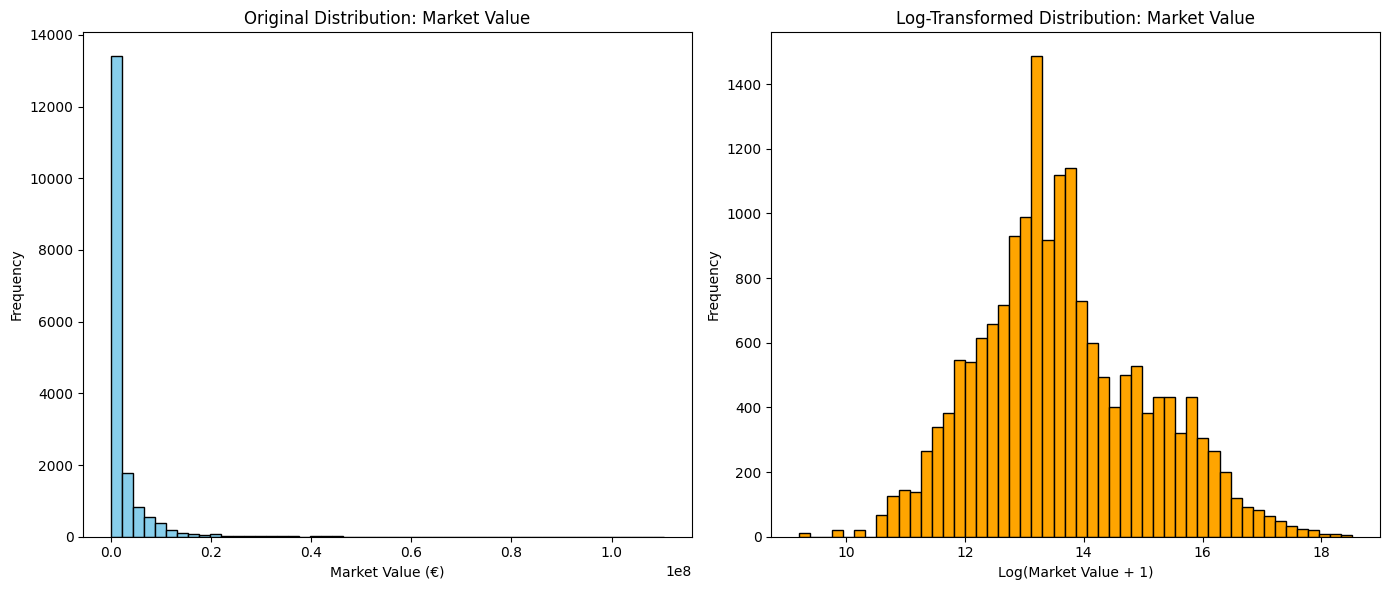

In [ ]:
plt.figure(figsize=(14, 6))

# Original distribution
plt.subplot(1, 2, 1)
plt.hist(data['value_euro'], bins=50, color='skyblue', edgecolor='black')
plt.title('Original Distribution: Market Value')
plt.xlabel('Market Value (€)')
plt.ylabel('Frequency')

# Transformed distribution
plt.subplot(1, 2, 2)
plt.hist(data['value_euro_log'], bins=50, color='orange', edgecolor='black')
plt.title('Log-Transformed Distribution: Market Value')
plt.xlabel('Log(Market Value + 1)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


# Feature Scaling

Test whether standarization of numerical features to be in similar ranges is viable, or if it skews the results.

Scale is very important: height_cm vs skill_moves can disproportionately influence the model.

In [ ]:
from sklearn.preprocessing import StandardScaler

# List of numerical features to scale
numeric_features = [
    'age', 'height_cm', 'weight_kgs', 'overall_rating', 'potential', 'wage_euro',
    'finishing', 'short_passing', 'dribbling', 'long_passing', 'ball_control',
    'acceleration', 'sprint_speed', 'balance', 'shot_power', 'stamina',
    'long_shots', 'positioning'
]

scaler = StandardScaler()
data[numeric_features] = scaler.fit_transform(data[numeric_features])


Description & visualization.

In [ ]:
# Summary statistics of features before scaling
print("Summary Statistics BEFORE Scaling:")
print(data[numeric_features].describe())

# Summary statistics of features after scaling
print("Summary Statistics AFTER Scaling:")
scaled_features = scaler.transform(data[numeric_features])
scaled_df = pd.DataFrame(scaled_features, columns=numeric_features)
print(scaled_df.describe())


Summary Statistics BEFORE Scaling:
                age     height_cm    weight_kgs  overall_rating     potential  \
count  1.769900e+04  1.769900e+04  1.769900e+04    1.769900e+04  1.769900e+04   
mean   1.798537e-16 -2.011311e-15 -1.612260e-15    7.451084e-16  3.340141e-16   
std    1.000028e+00  1.000028e+00  1.000028e+00    1.000028e+00  1.000028e+00   
min   -1.816868e+00 -1.605208e+00 -3.583225e+00   -2.756605e+00 -3.496599e+00   
25%   -7.523218e-01 -1.424242e+00 -7.607018e-01   -6.058821e-01 -7.253611e-01   
50%   -1.135941e-01  2.348601e-02 -6.918364e-02   -3.235584e-02 -7.330518e-02   
75%    7.380429e-01  7.473501e-01  6.364472e-01    6.845520e-01  5.787508e-01   
max    4.357500e+00  2.195078e+00  4.926683e+00    3.982328e+00  3.839031e+00   

          wage_euro     finishing  short_passing     dribbling  long_passing  \
count  17699.000000  1.769900e+04   1.769900e+04  1.769900e+04  1.769900e+04   
mean       0.000000 -1.413137e-16  -2.055471e-16 -1.541604e-16  1.284670e-1

Key things to take into account here:

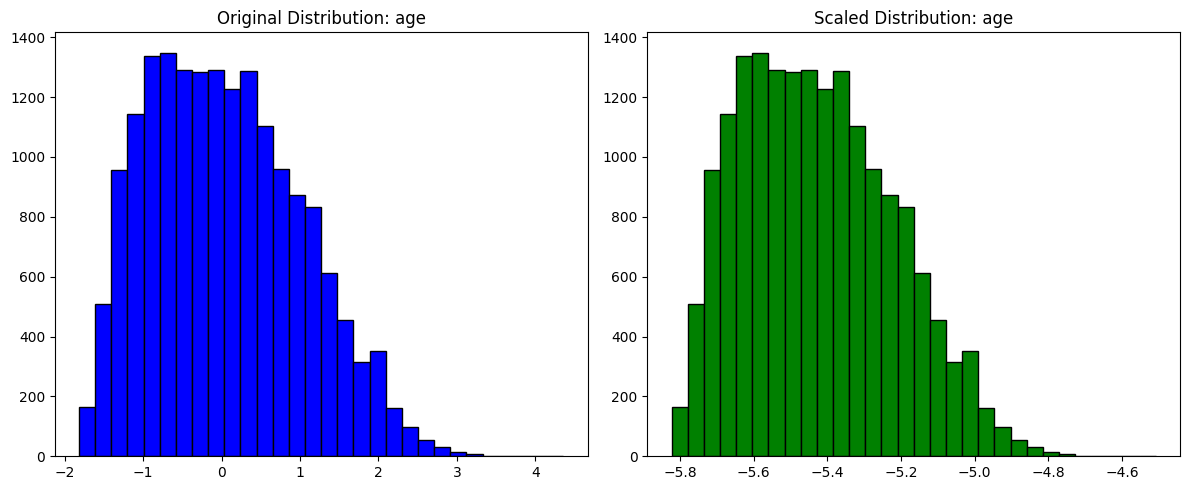

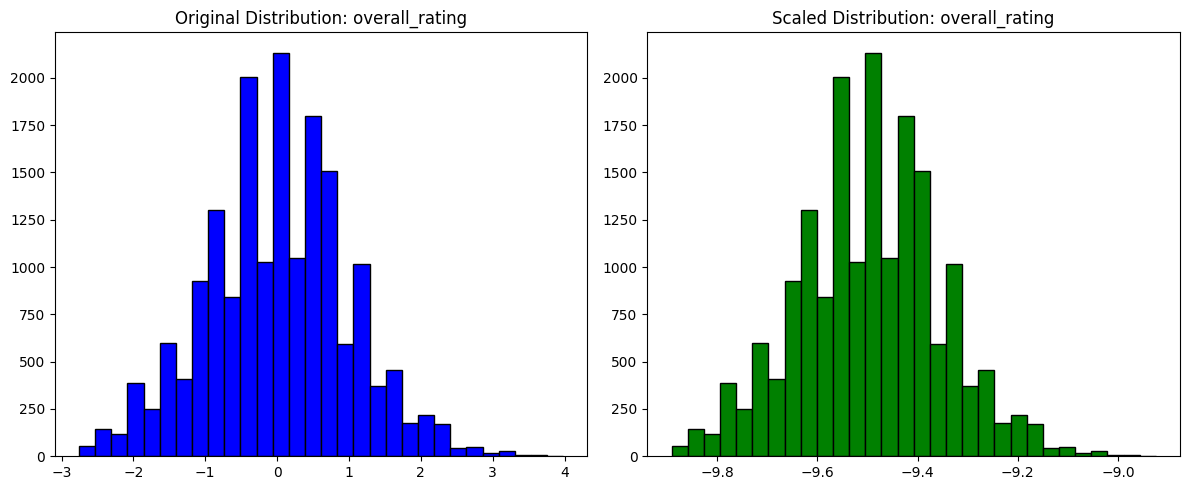

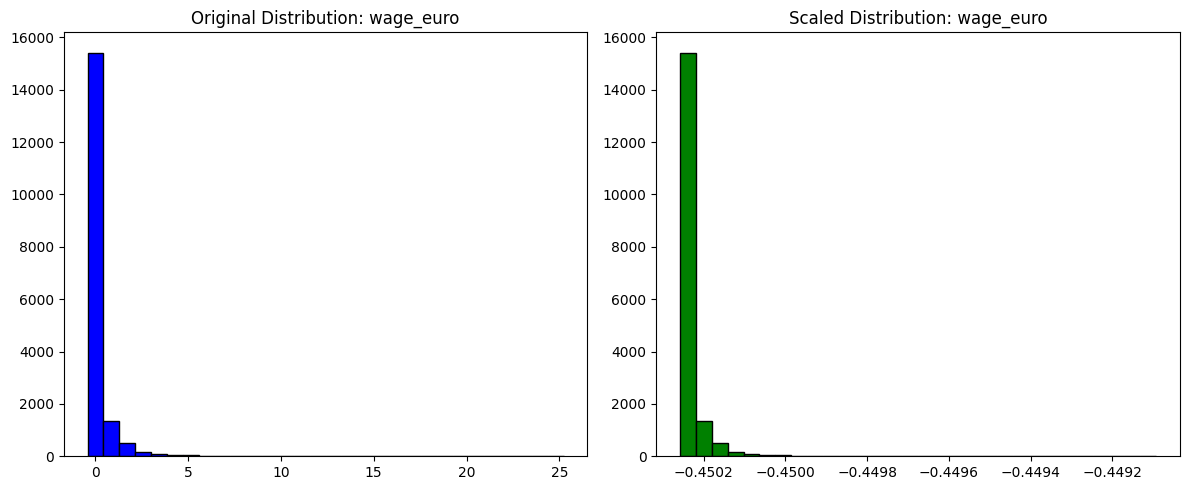

In [ ]:
# Visualize a few features before and after scaling
features_to_visualize = ['age', 'overall_rating', 'wage_euro']

for feature in features_to_visualize:
    plt.figure(figsize=(12, 5))

    # Original
    plt.subplot(1, 2, 1)
    plt.hist(data[feature], bins=30, color='blue', edgecolor='black')
    plt.title(f"Original Distribution: {feature}")

    # Scaled
    plt.subplot(1, 2, 2)
    plt.hist(scaled_df[feature], bins=30, color='green', edgecolor='black')
    plt.title(f"Scaled Distribution: {feature}")

    plt.tight_layout()
    plt.show()


# Outlier Treatment

In [ ]:
from scipy.stats.mstats import winsorize

# Example: Cap extreme values for 'value_euro' and 'wage_euro'
data['value_euro'] = winsorize(data['value_euro'], limits=[0.01, 0.01])  # Top/bottom 1%
data['wage_euro'] = winsorize(data['wage_euro'], limits=[0.01, 0.01])


# Outlier treatment visualization for 'value_euro' and 'wage_euro'

We've decided to scrap this section since our data is pretty much exactly the same...

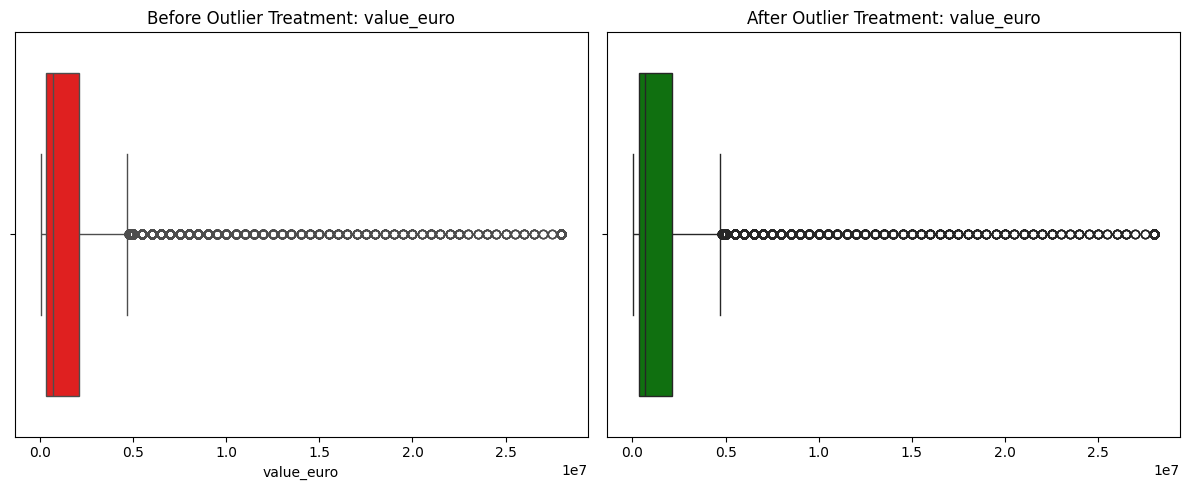

Range of value_euro BEFORE treatment: 50000.0 - 28000000.0
Range of value_euro AFTER treatment: 50000.0 - 28000000.0


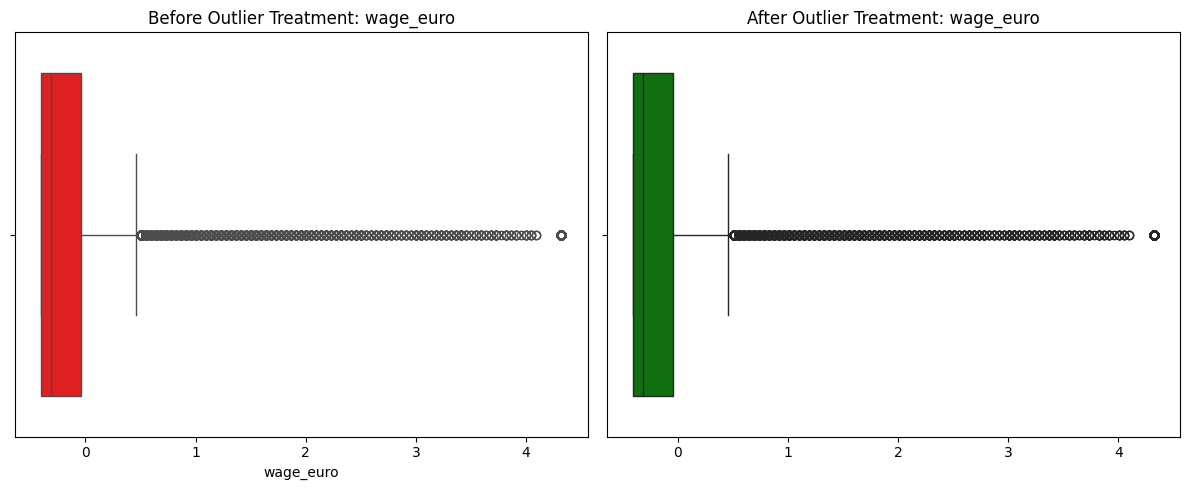

Range of wage_euro BEFORE treatment: -0.40478452188136166 - 4.322523823806716
Range of wage_euro AFTER treatment: -0.40478452188136166 - 4.322523823806716


In [ ]:
features_to_check = ['value_euro', 'wage_euro']

for feature in features_to_check:
    plt.figure(figsize=(12, 5))

    # Boxplot before
    plt.subplot(1, 2, 1)
    sns.boxplot(x=data[feature], color='red')
    plt.title(f"Before Outlier Treatment: {feature}")

    # Boxplot after
    plt.subplot(1, 2, 2)
    sns.boxplot(x=winsorize(data[feature], limits=[0.01, 0.01]), color='green')
    plt.title(f"After Outlier Treatment: {feature}")

    plt.tight_layout()
    plt.show()

    # Print value ranges
    print(f"Range of {feature} BEFORE treatment: {data[feature].min()} - {data[feature].max()}")
    treated_feature = winsorize(data[feature], limits=[0.01, 0.01])
    print(f"Range of {feature} AFTER treatment: {treated_feature.min()} - {treated_feature.max()}")


# options:


*   Winsorization: Caps extreme values at a specific percentile.


*   Clipping: Limits values to a certain range.

# Overall Changes:

Sumary:


# Exploratory Data Analysis (EDA)

Univariate Analysis

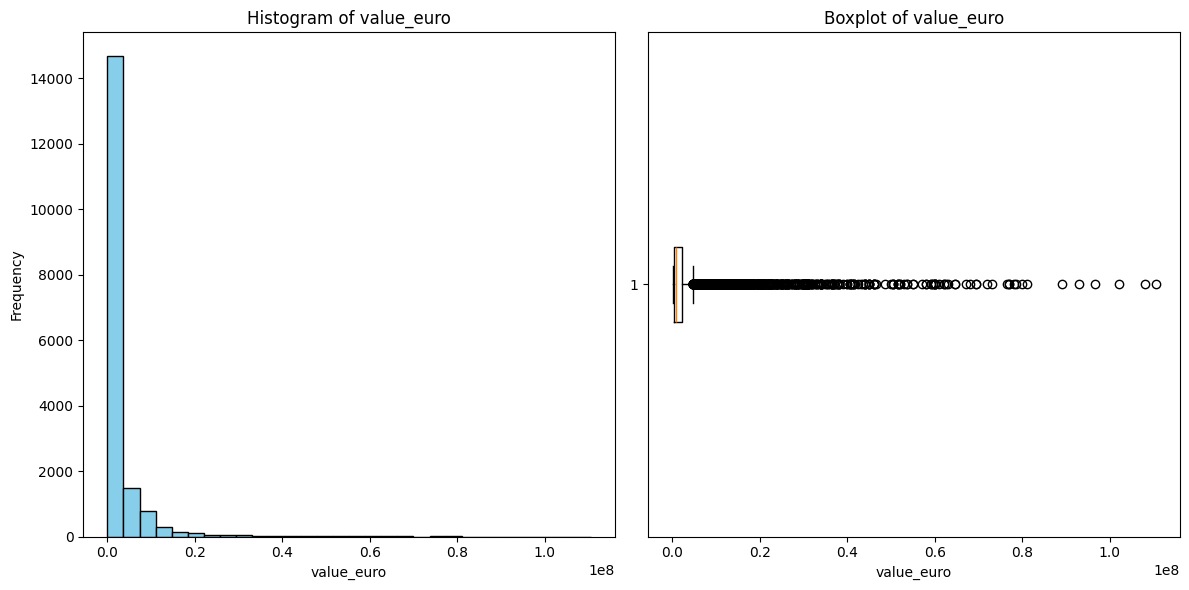

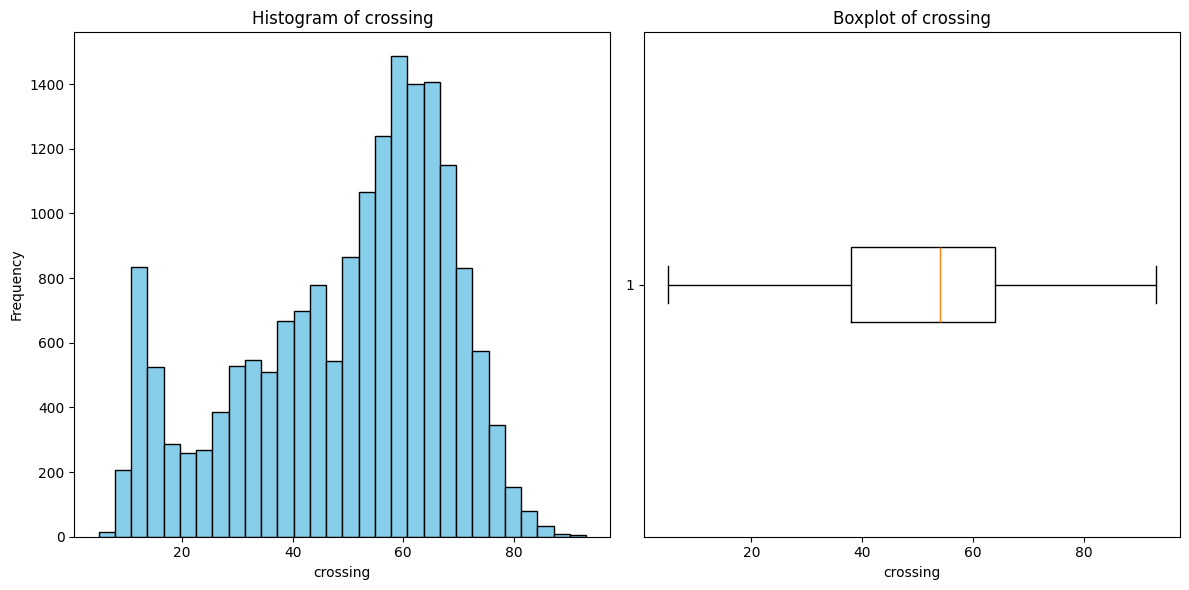

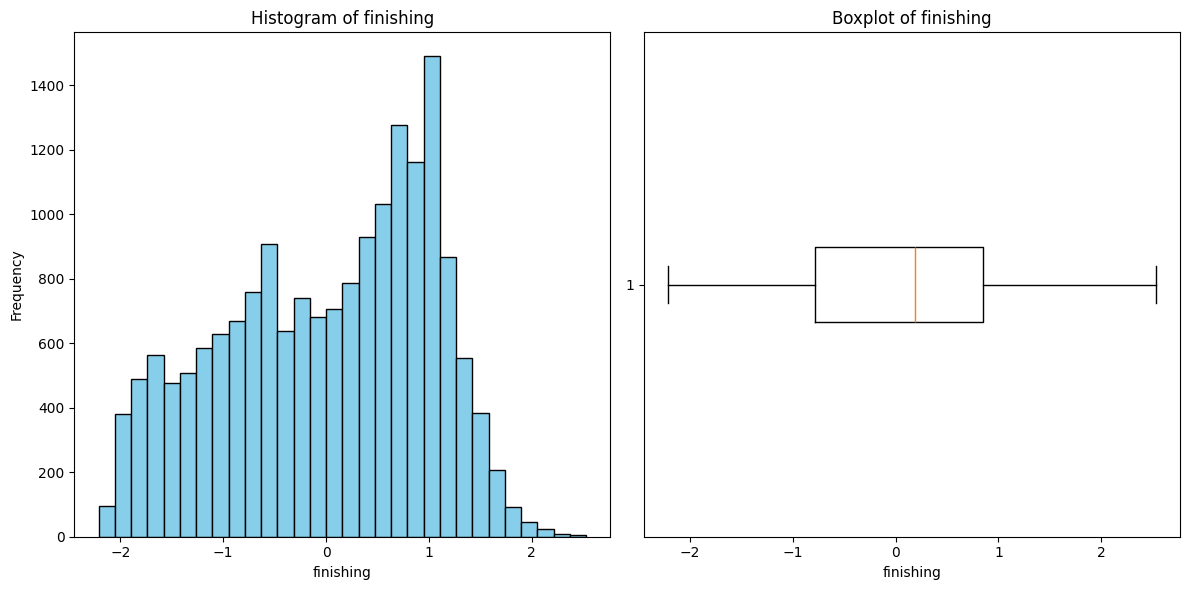

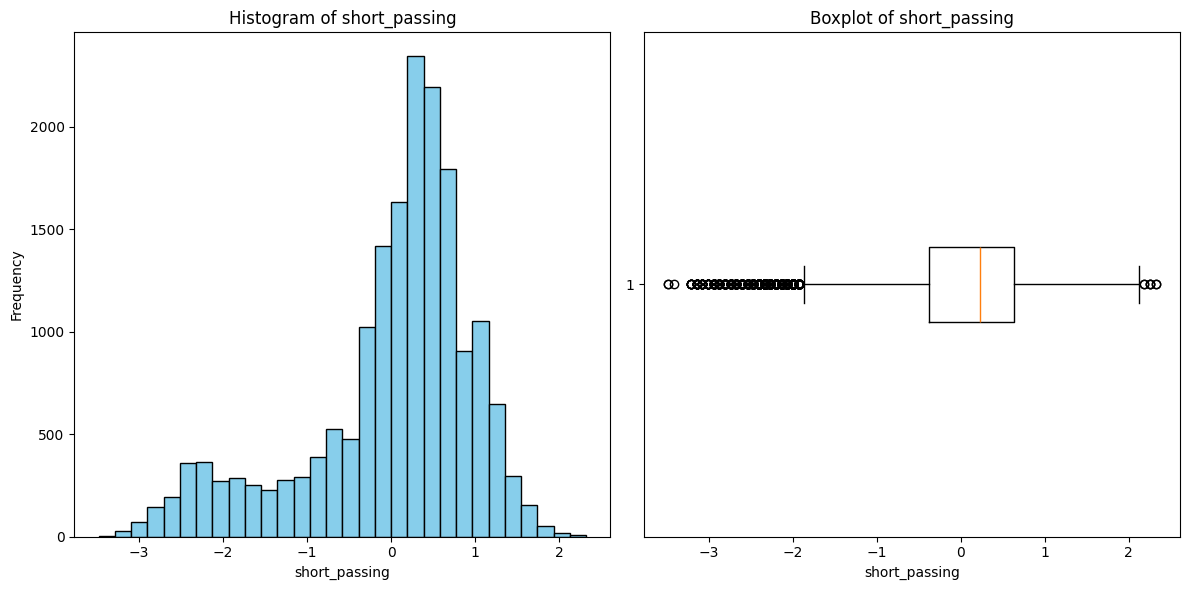

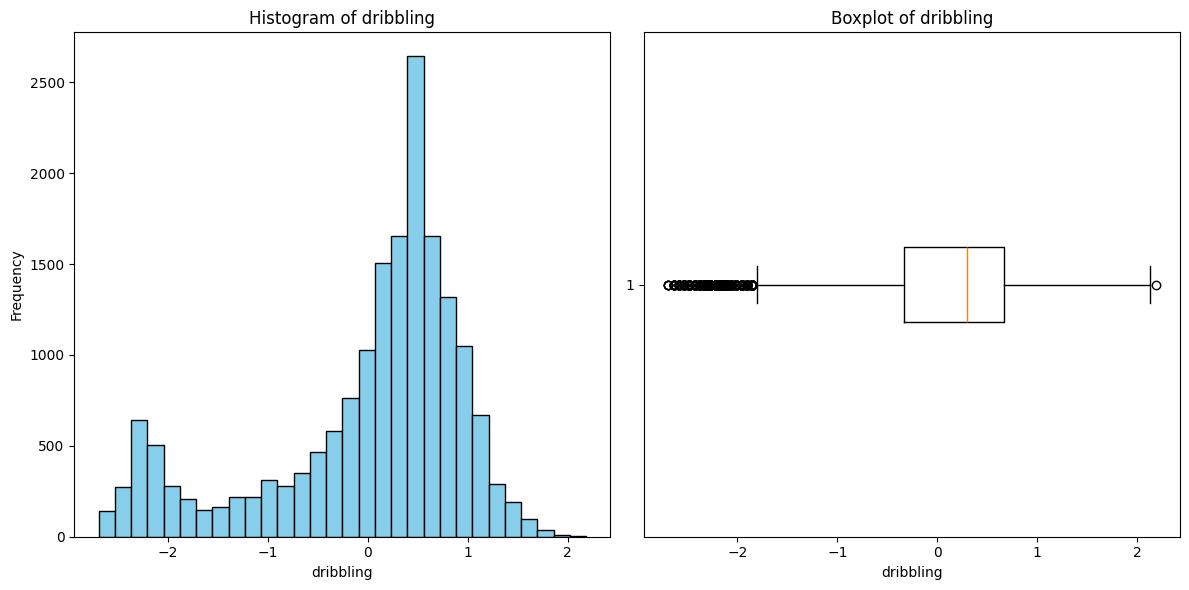

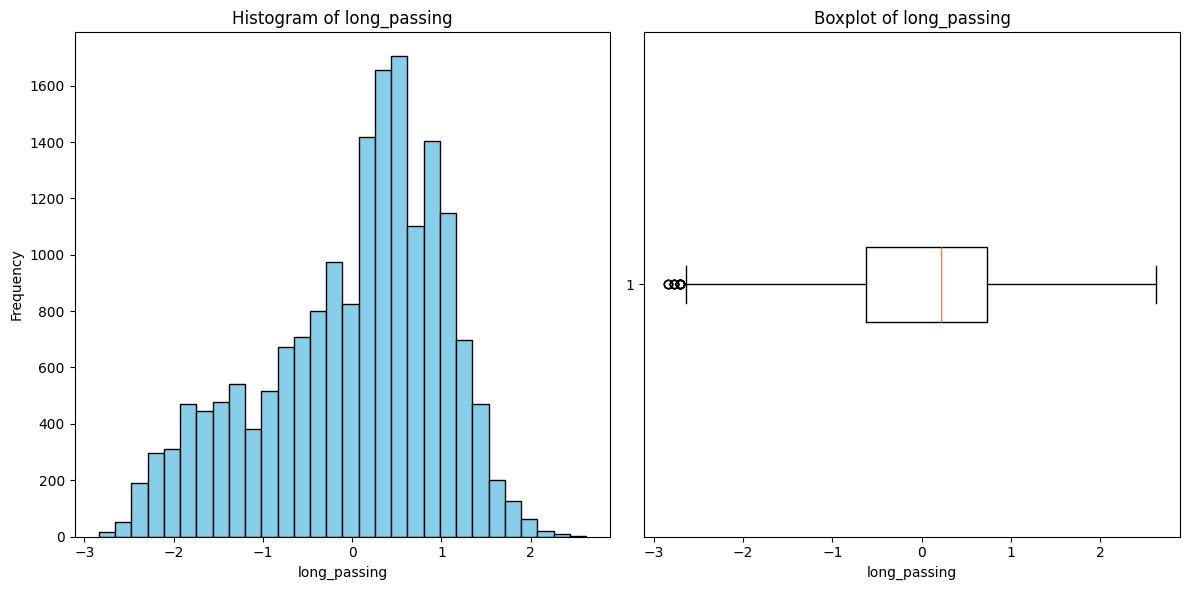

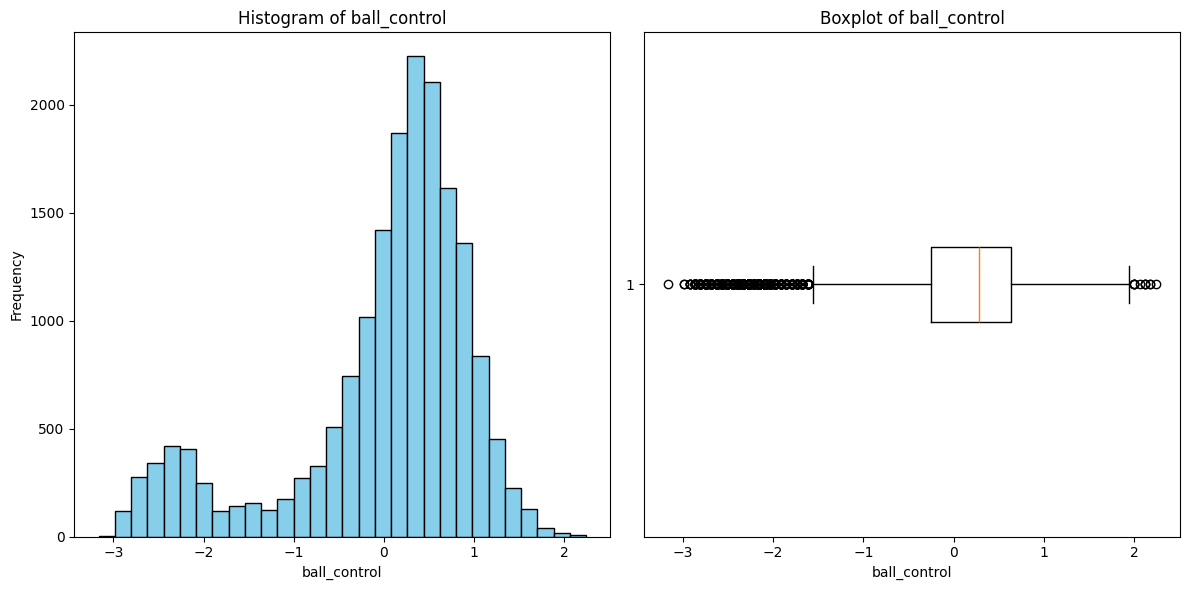

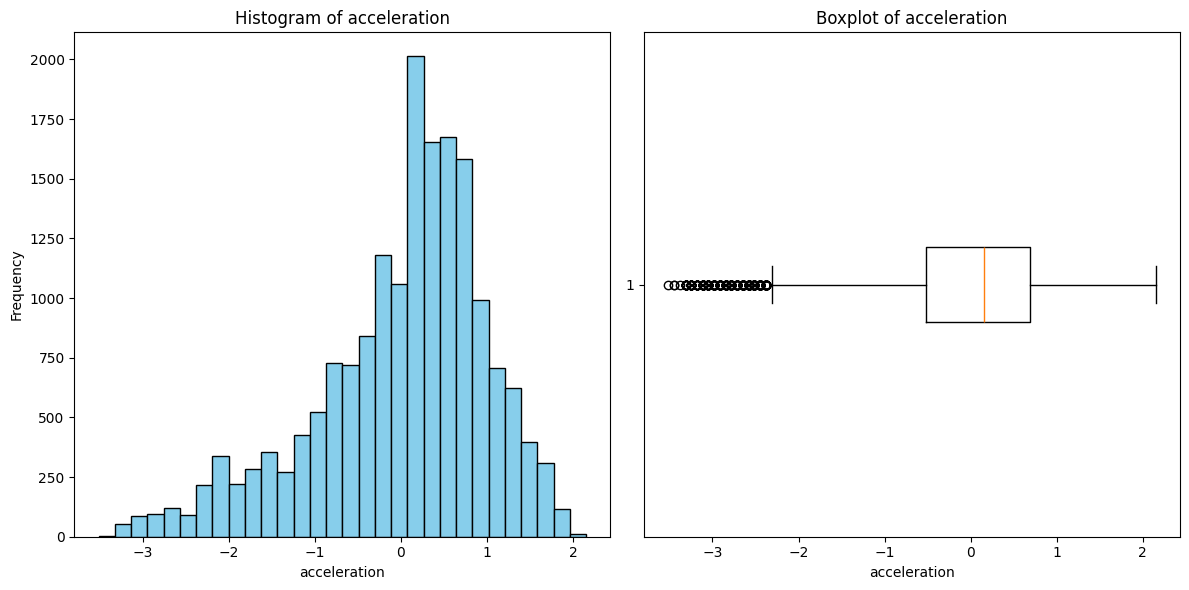

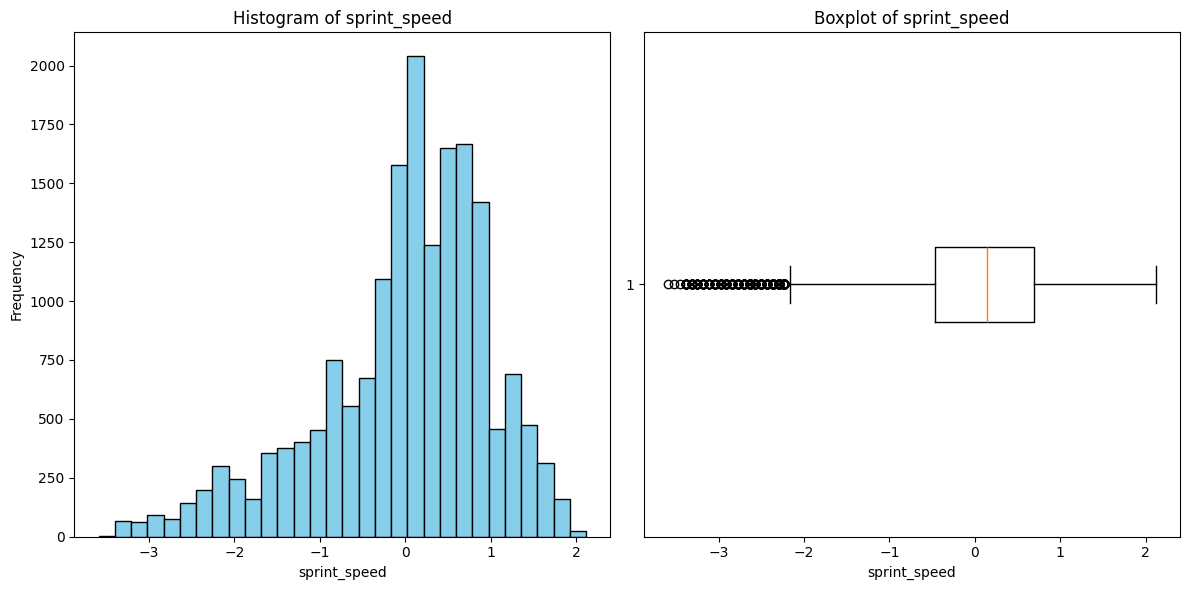

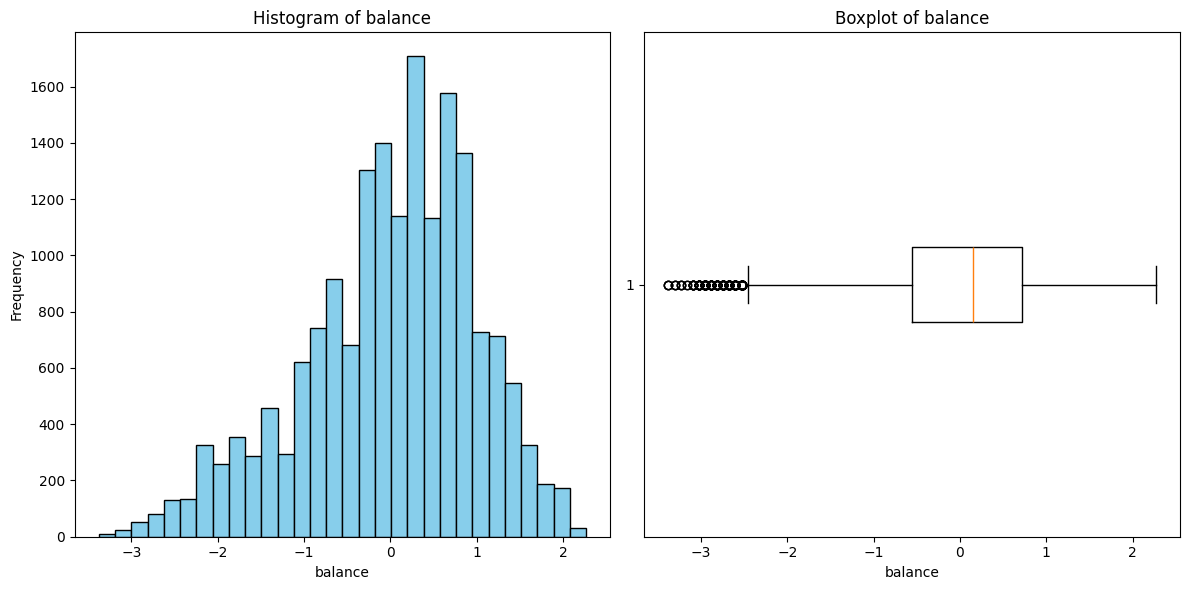

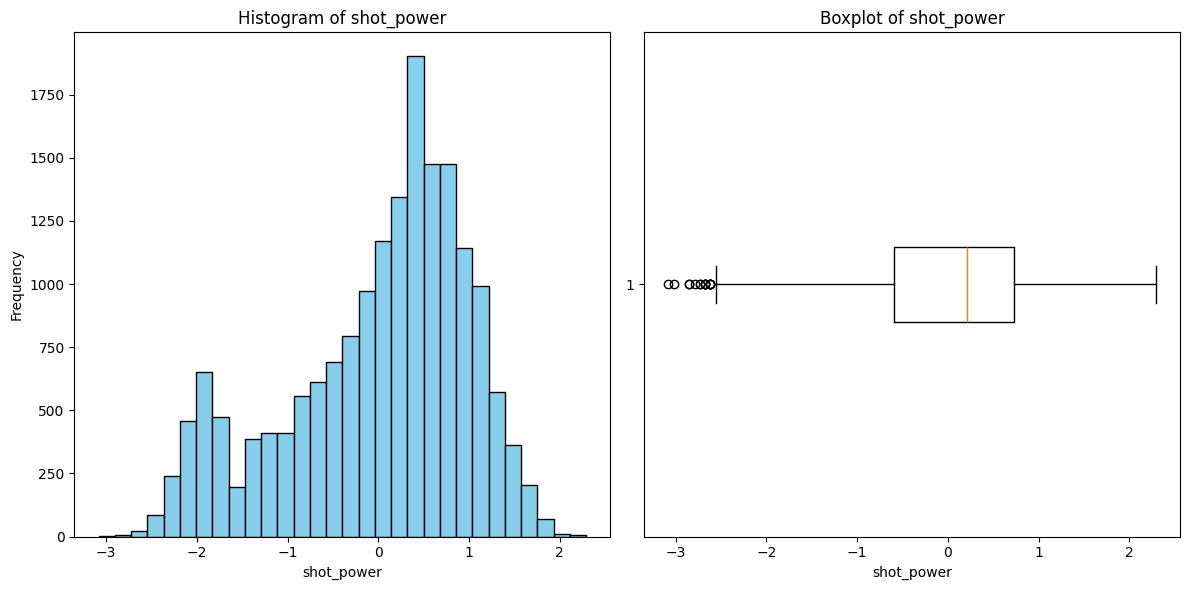

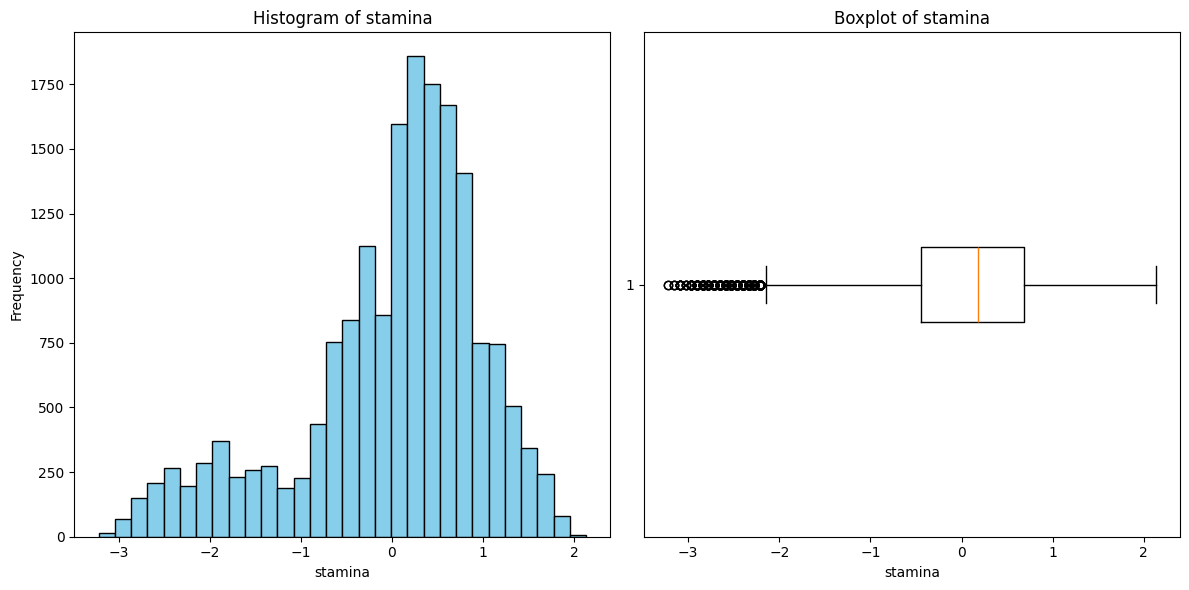

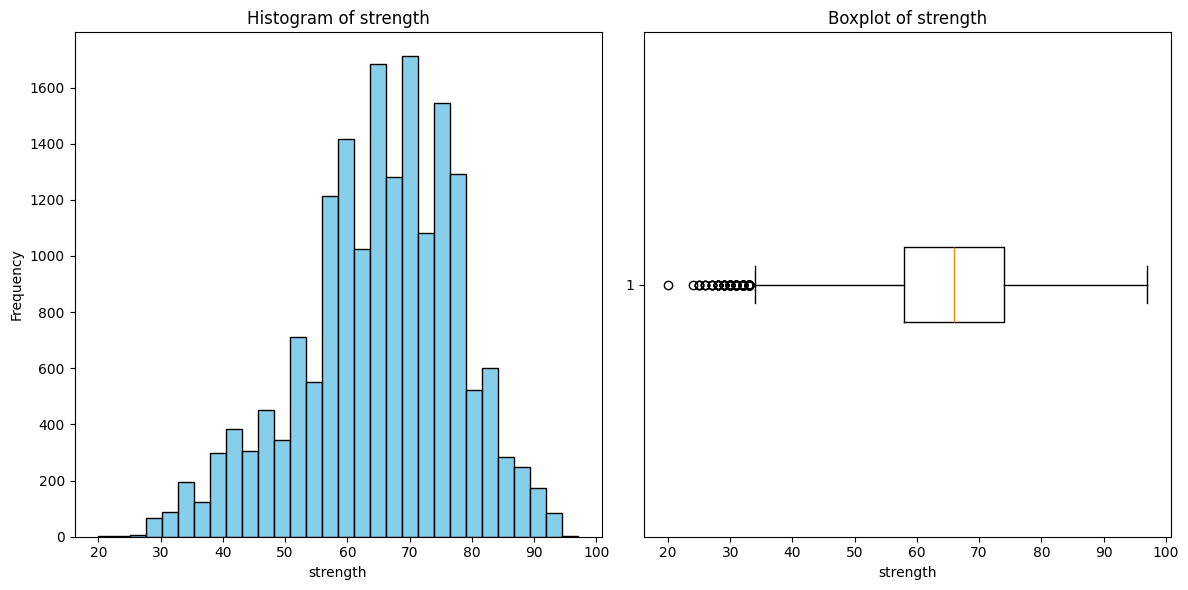

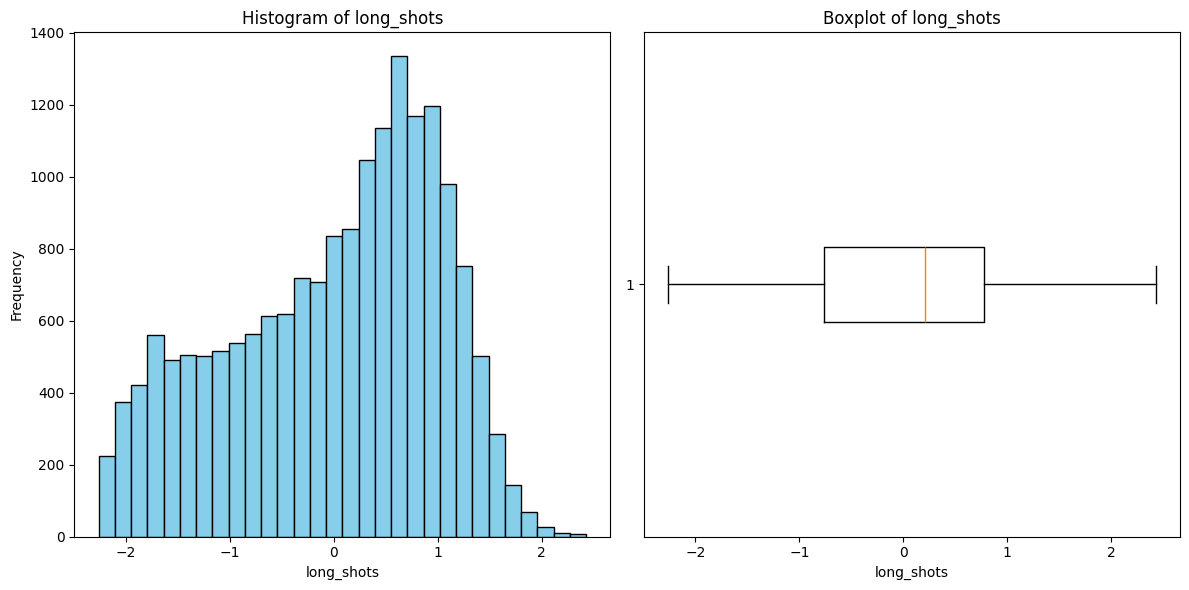

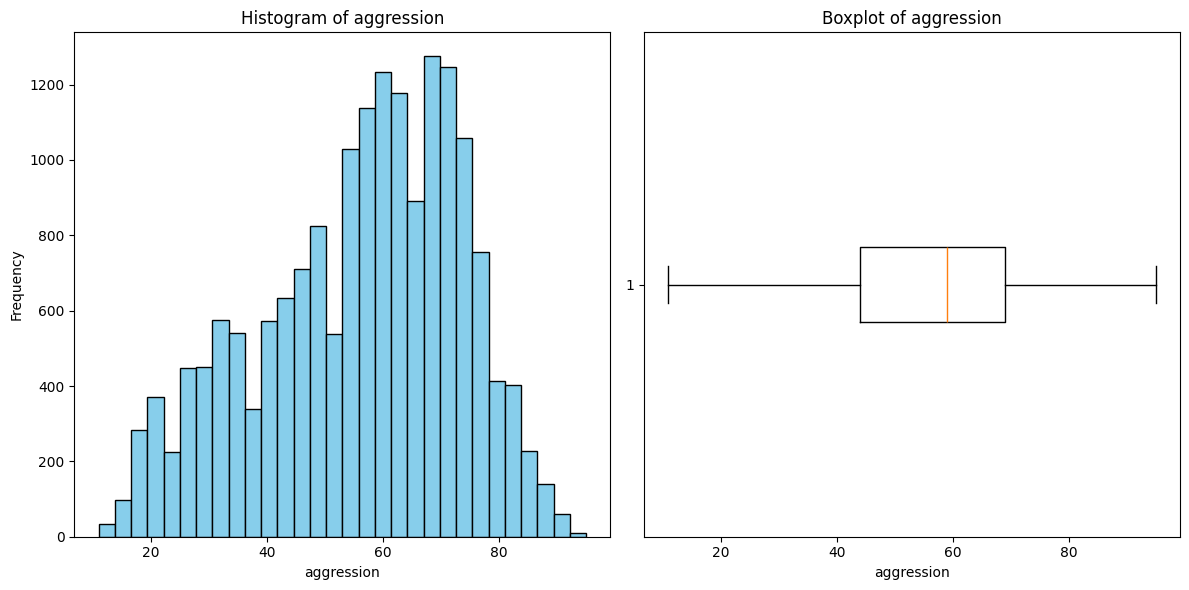

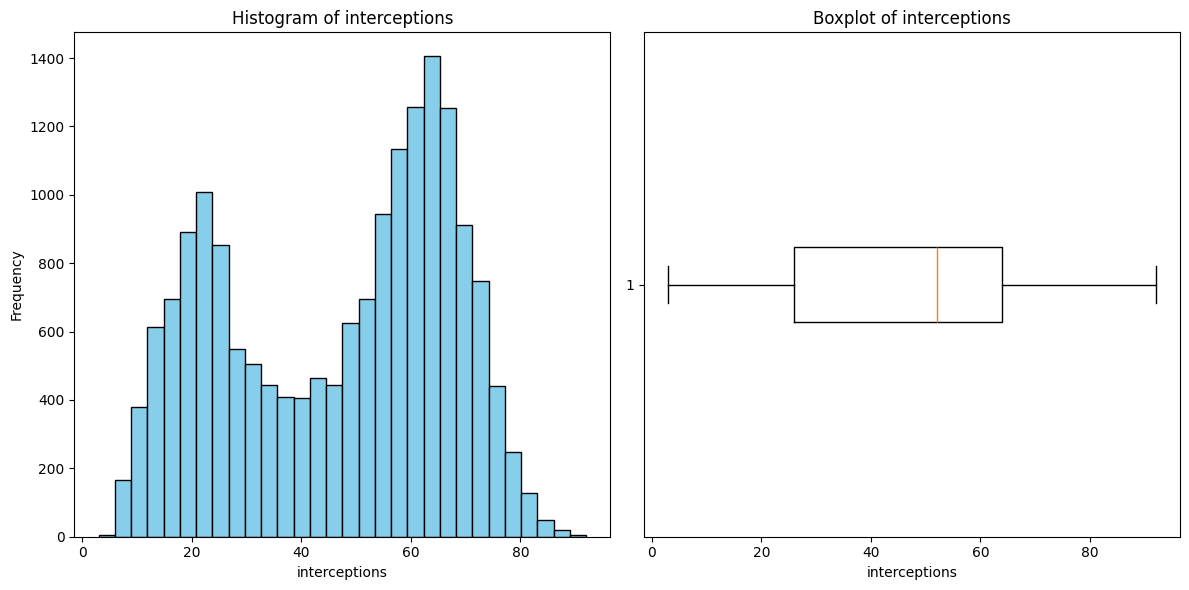

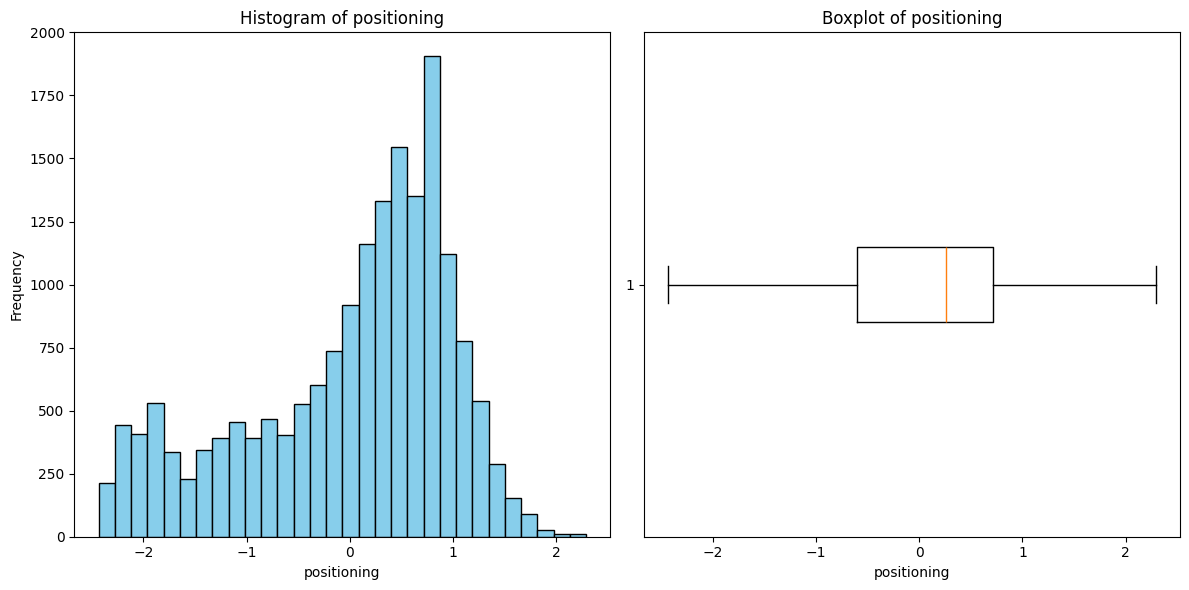

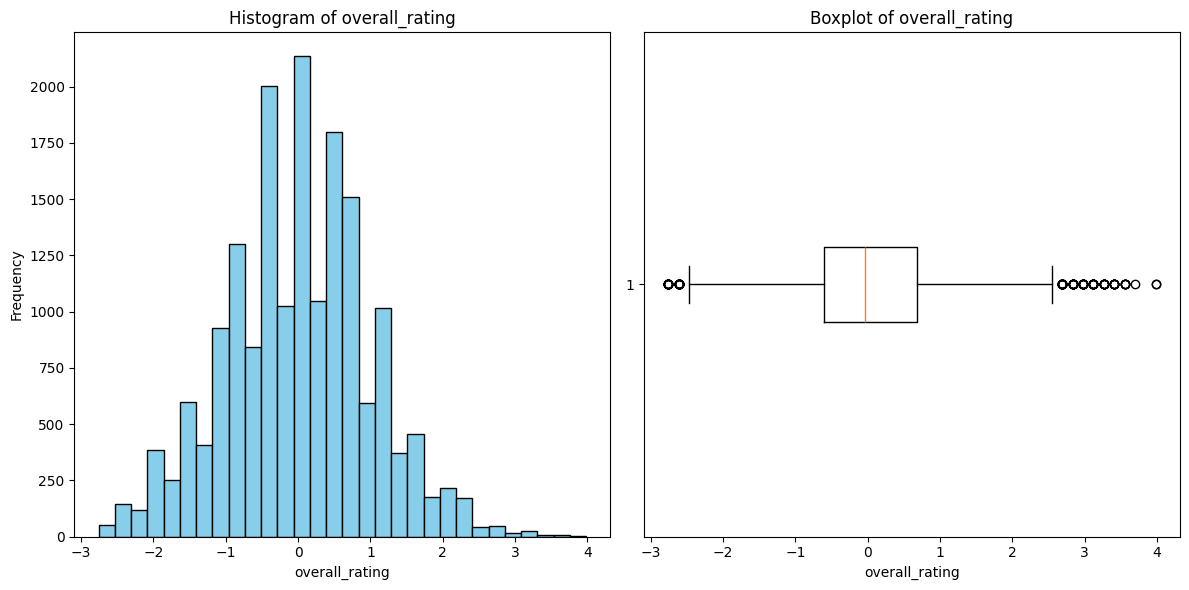

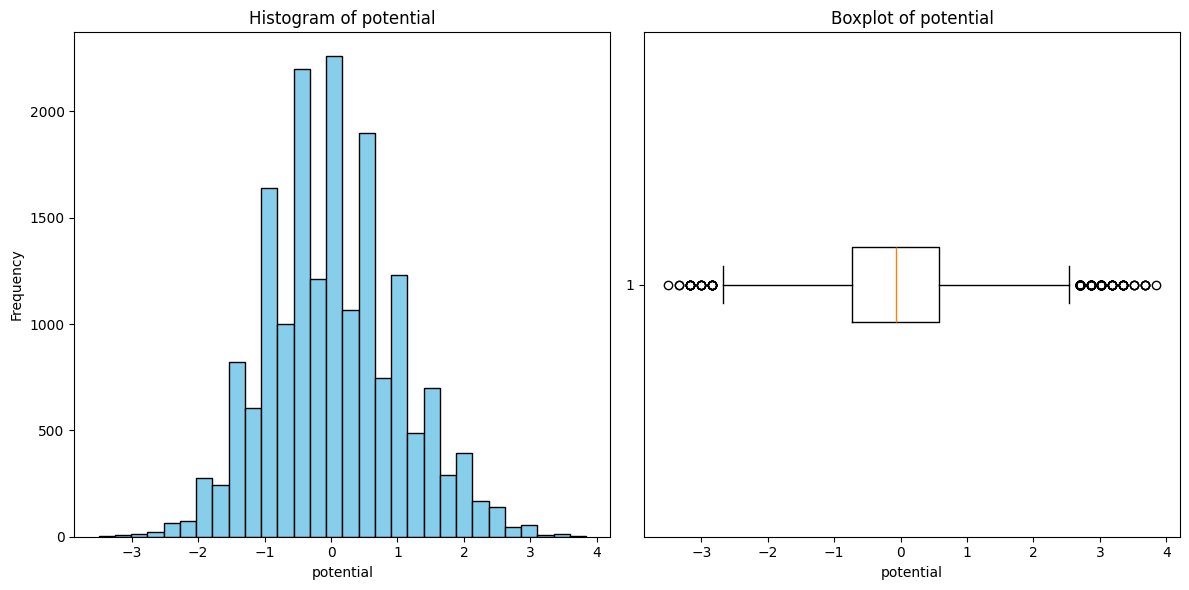

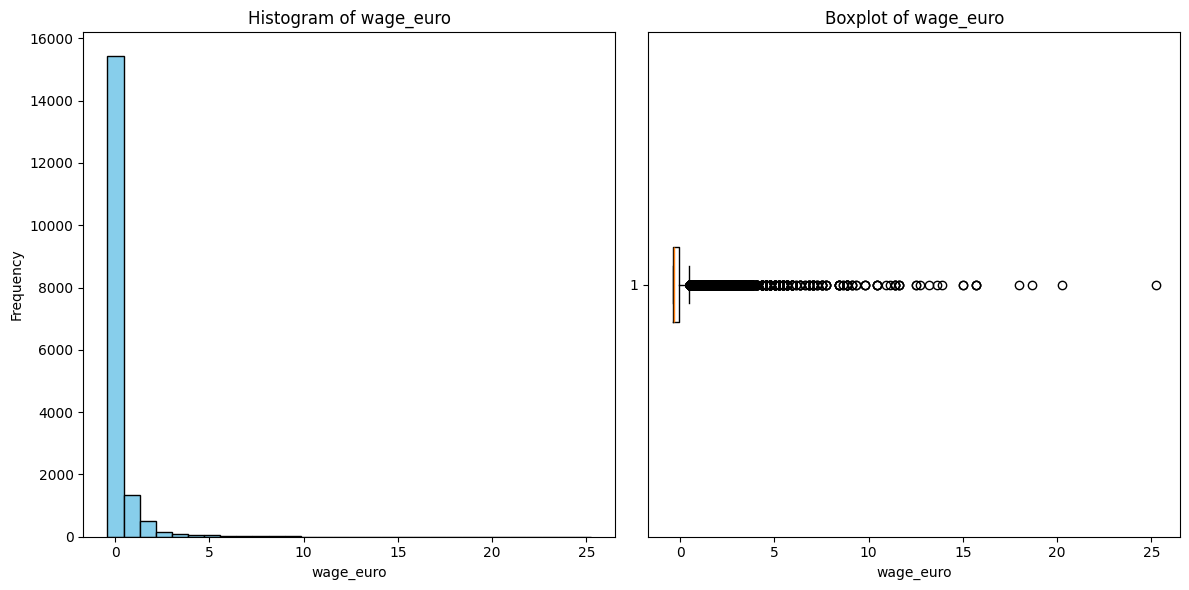

In [ ]:
# Updated list of relevant columns for analysis
columns_to_analyze = [
    'value_euro', 'crossing', 'finishing', 'short_passing', 'dribbling',
    'long_passing', 'ball_control', 'acceleration', 'sprint_speed',
    'balance', 'shot_power', 'stamina', 'strength', 'long_shots',
    'aggression', 'interceptions', 'positioning', 'overall_rating', 'potential', 'wage_euro'
]

# Filter the dataset to include only these columns
data_filtered = data[columns_to_analyze]

# Univariate analysis using histograms and boxplots
for col in data_filtered.columns:
    plt.figure(figsize=(12, 6))

    # Histogram
    plt.subplot(1, 2, 1)
    plt.hist(data_filtered[col].dropna(), bins=30, color='skyblue', edgecolor='black')
    plt.title(f'Histogram of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')

    # Boxplot
    plt.subplot(1, 2, 2)
    plt.boxplot(data_filtered[col].dropna(), vert=False)
    plt.title(f'Boxplot of {col}')
    plt.xlabel(col)

    plt.tight_layout()
    plt.show()

Bivariate Analysis

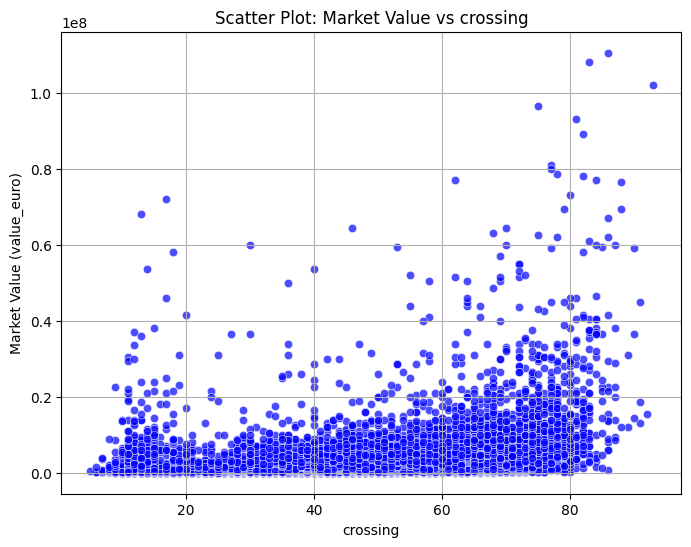

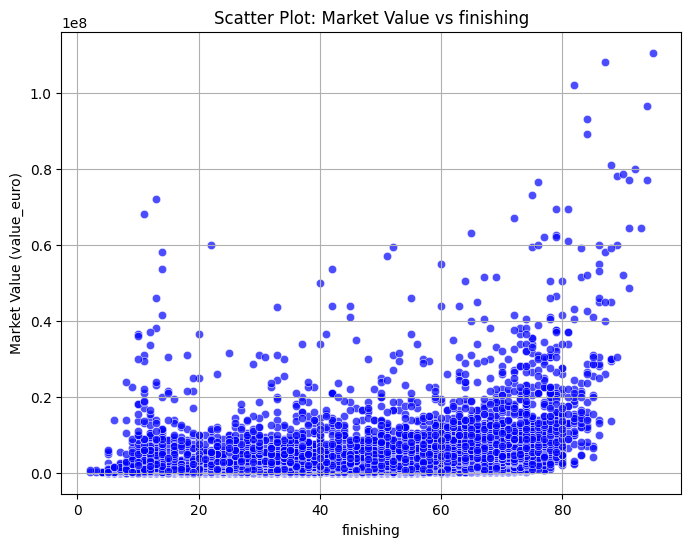

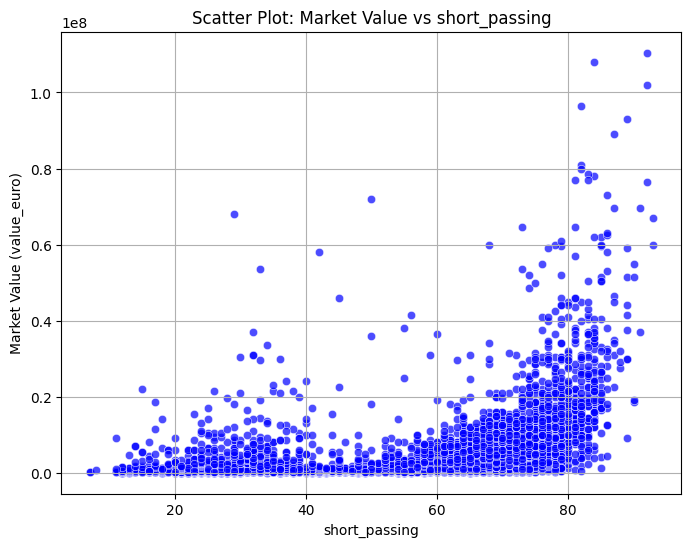

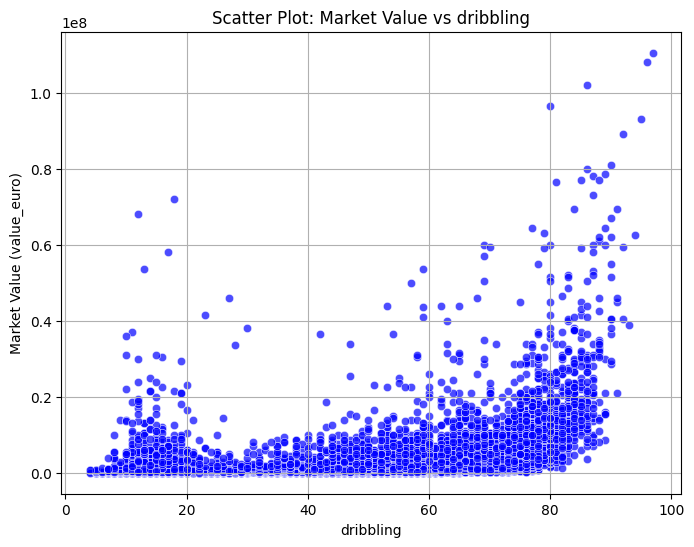

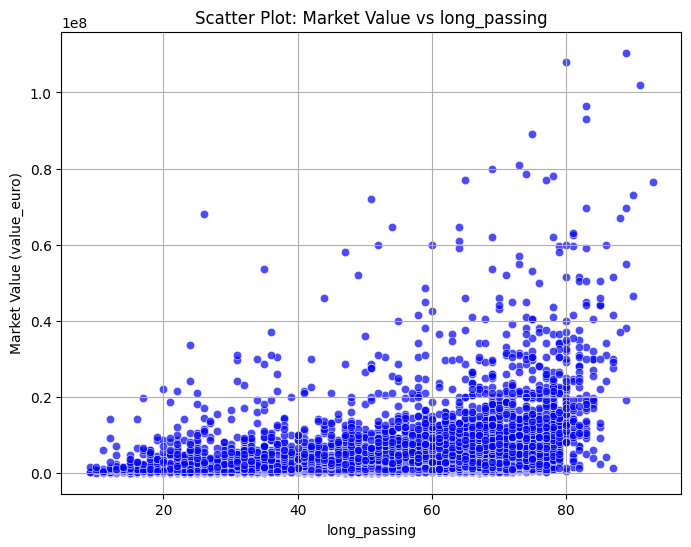

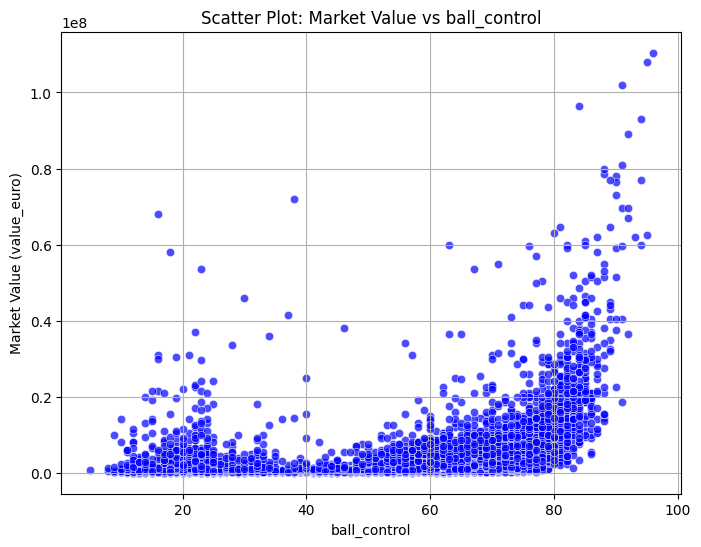

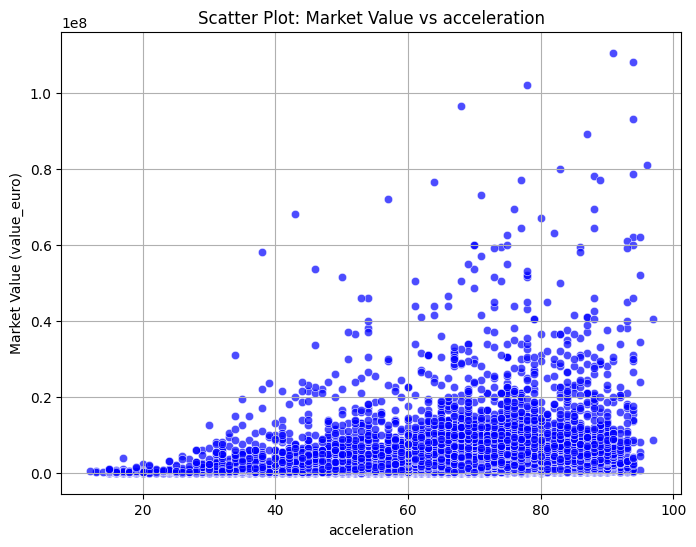

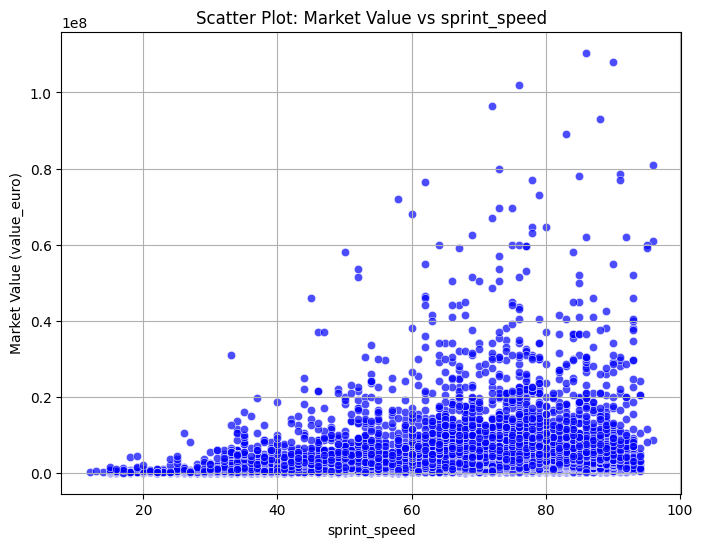

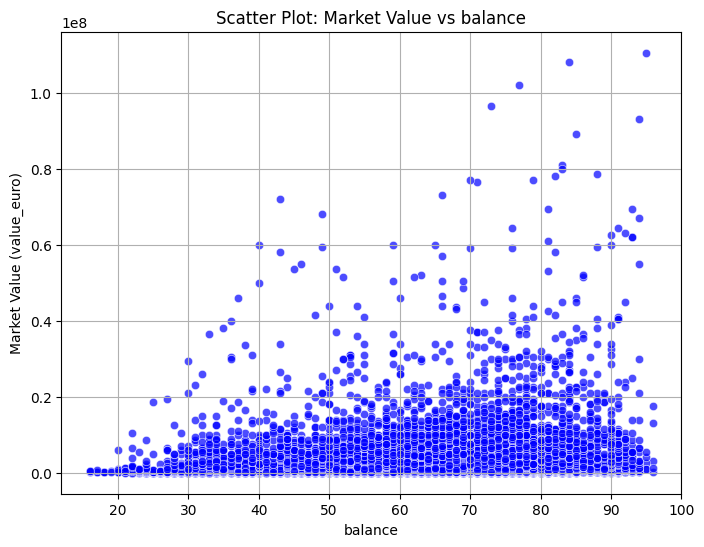

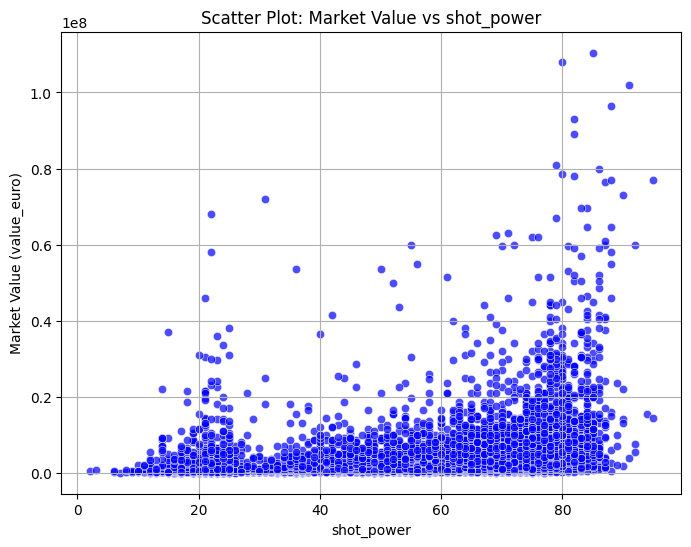

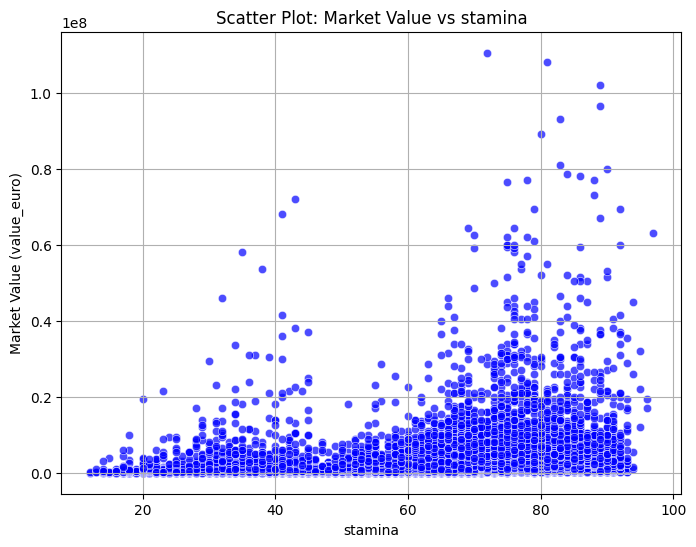

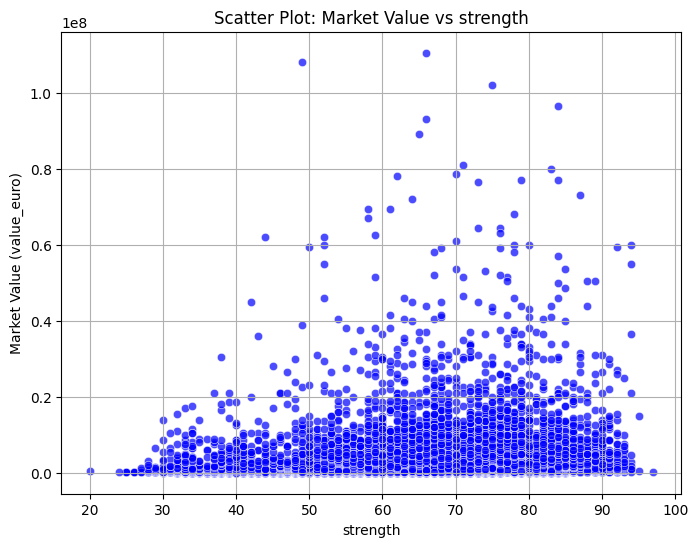

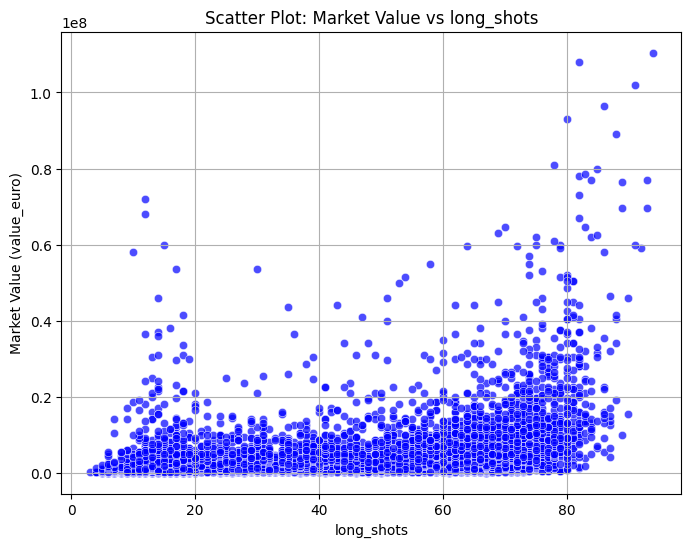

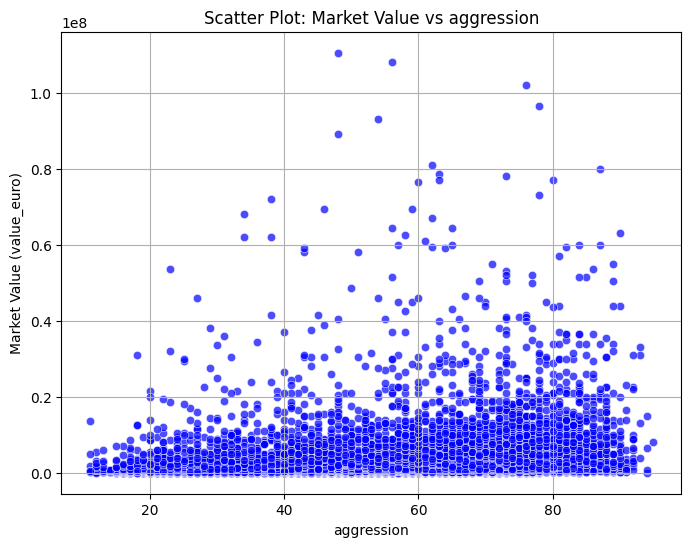

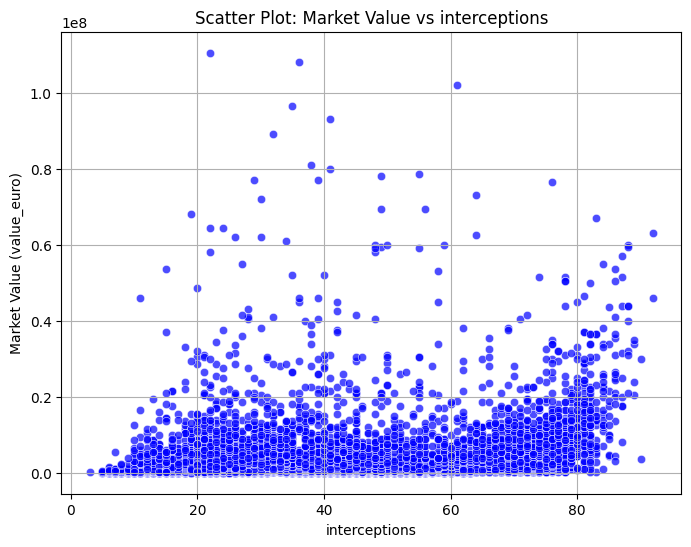

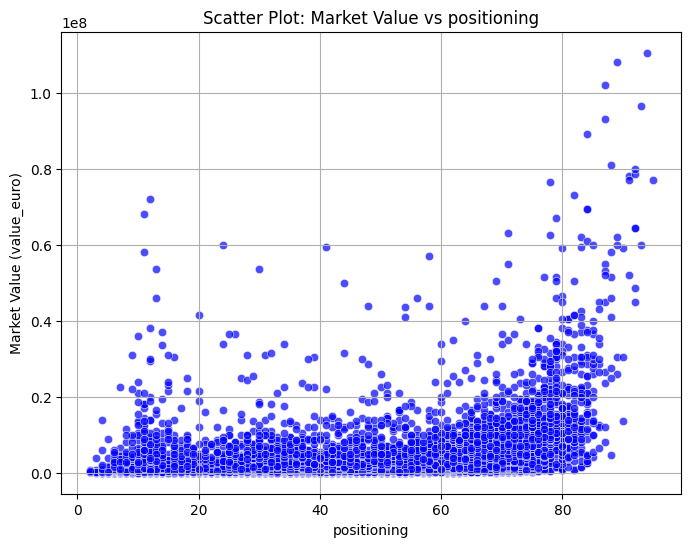

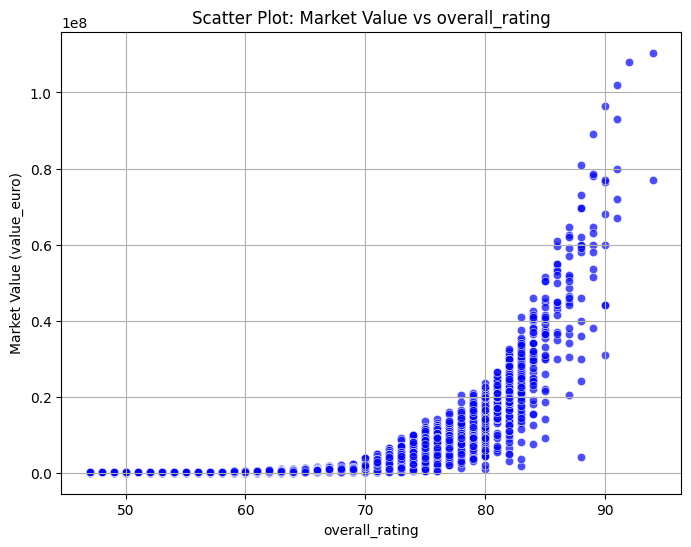

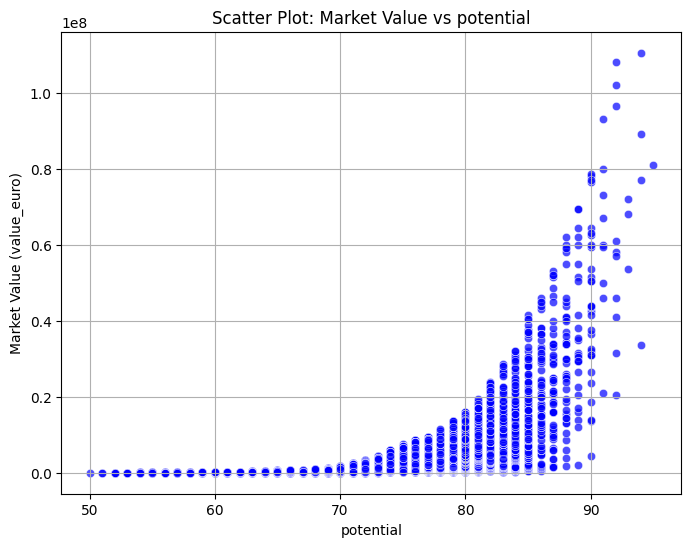

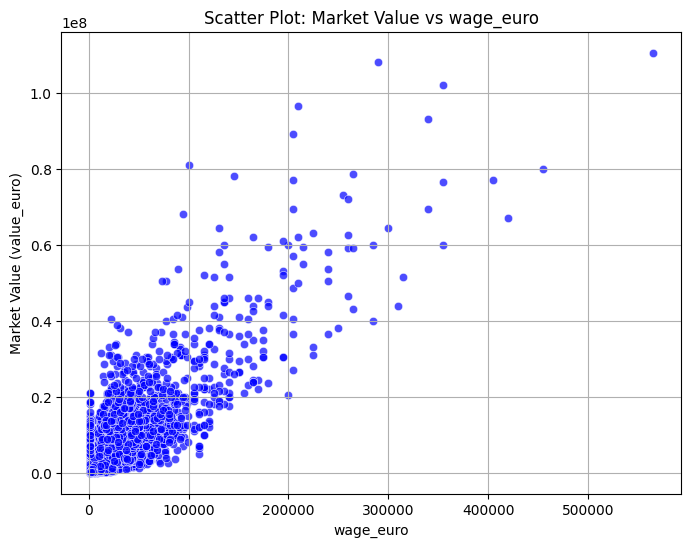

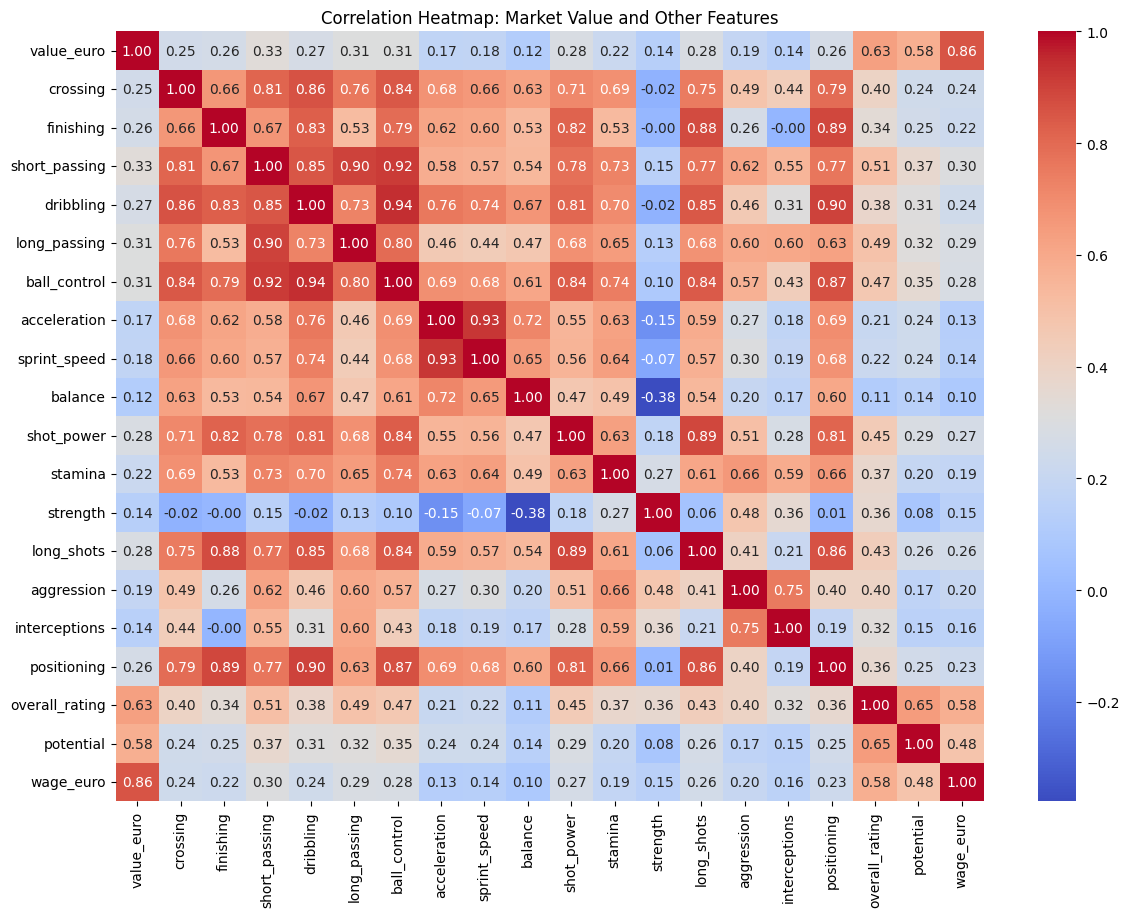

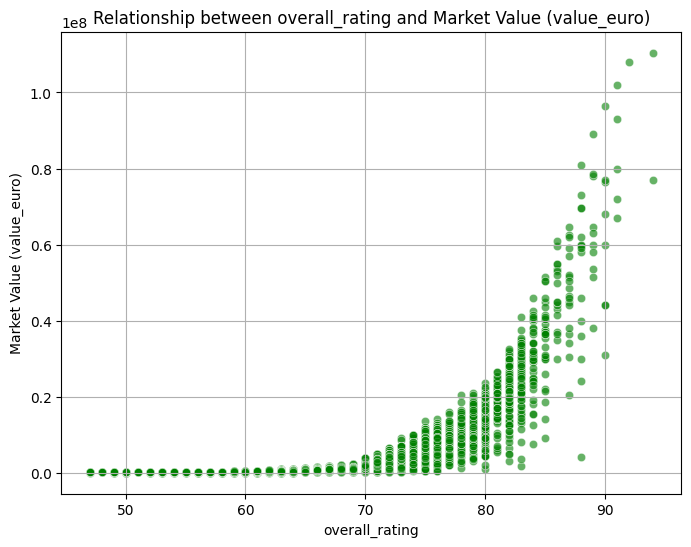

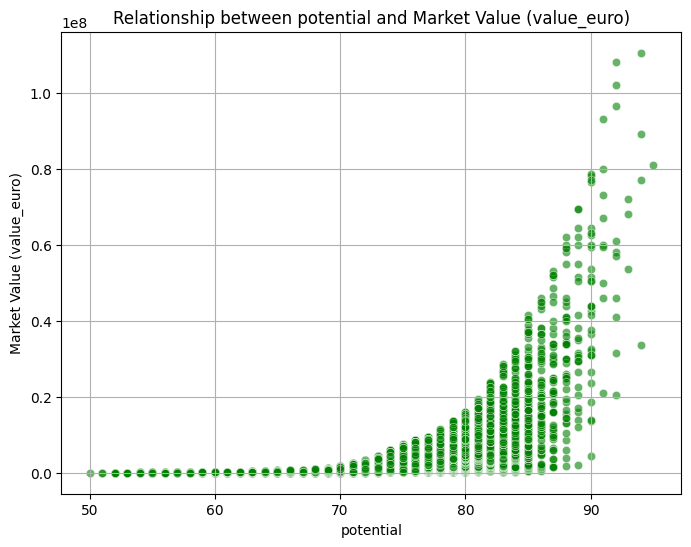

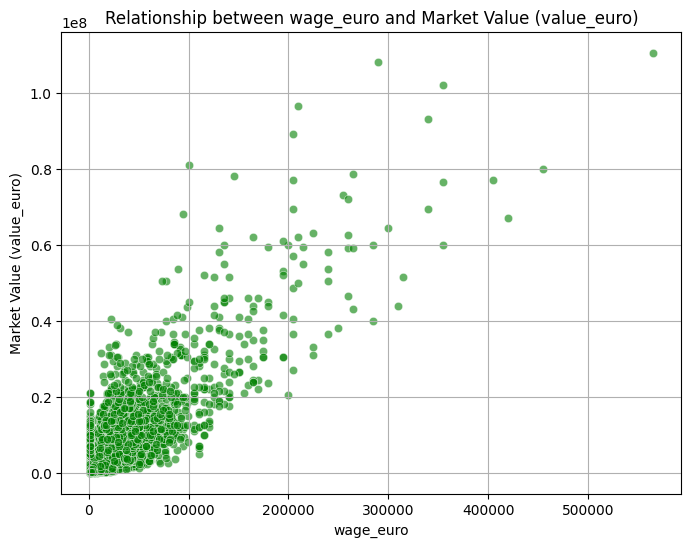

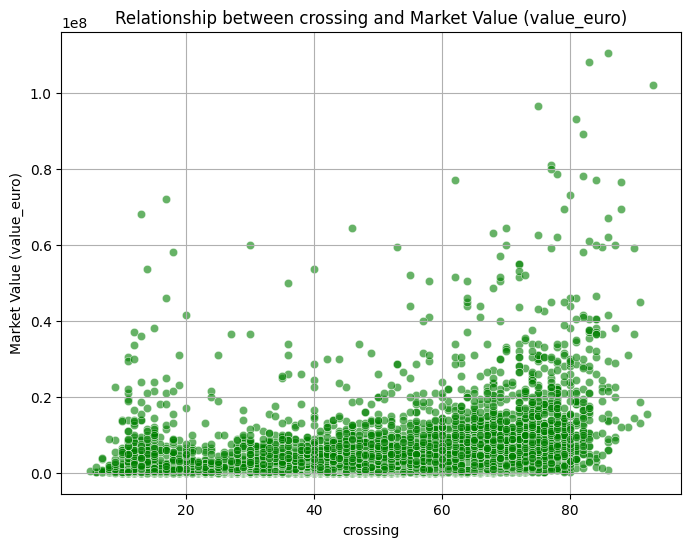

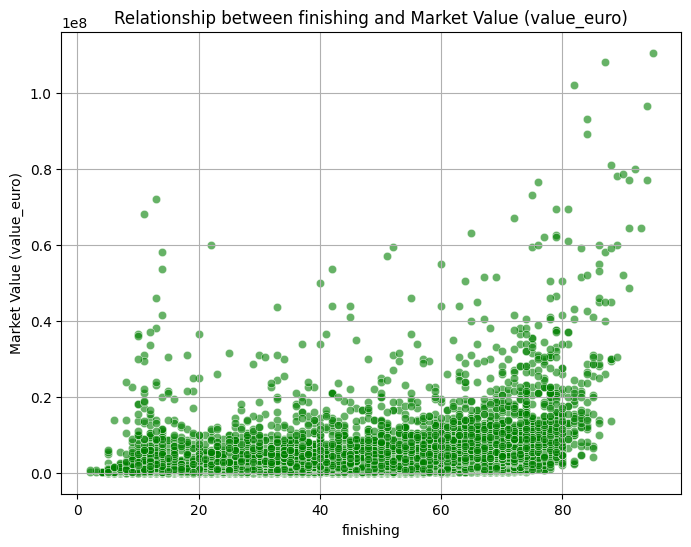

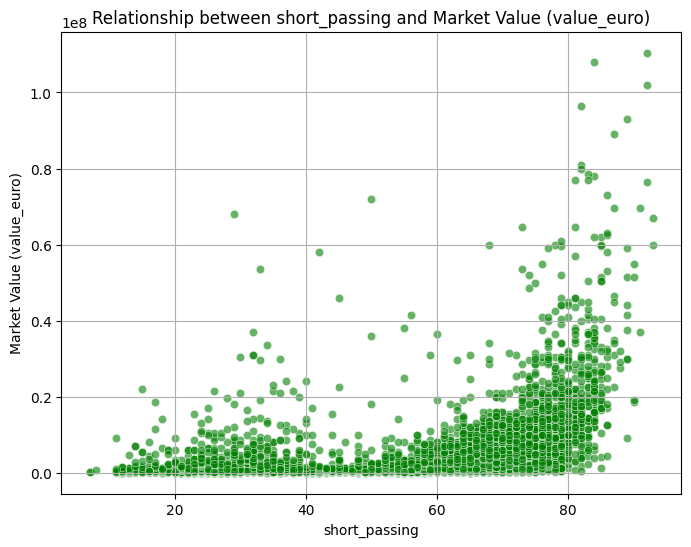

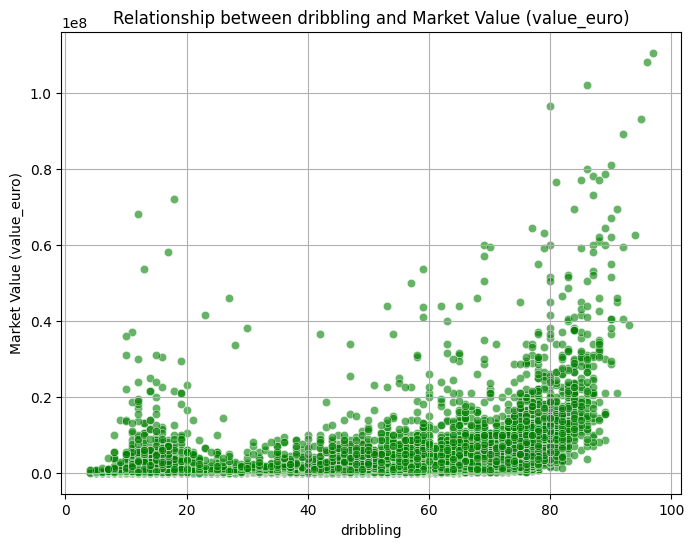

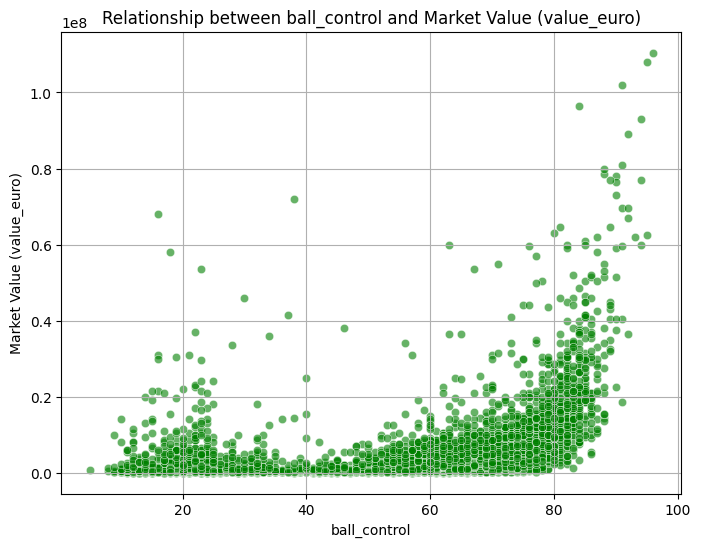

In [ ]:
import seaborn as sns

numeric_columns = data_filtered.select_dtypes(include=['number']).columns.tolist()

# Ensure 'value_euro' (market value) is in the dataset and numeric columns are selected
if 'value_euro' in numeric_columns:
    # Scatter plots: Relationships between market_value (value_euro) and other numeric features
    for col in numeric_columns:
        if col != 'value_euro':
            plt.figure(figsize=(8, 6))
            sns.scatterplot(data=data_filtered, x=col, y='value_euro', color='blue', alpha=0.7)
            plt.title(f'Scatter Plot: Market Value vs {col}')
            plt.xlabel(col)
            plt.ylabel('Market Value (value_euro)')
            plt.grid(True)
            plt.show()

    # Correlation heatmap: Show correlations between market_value and other numeric features
    correlation_matrix = data_filtered[numeric_columns].corr()

    plt.figure(figsize=(14, 10))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title('Correlation Heatmap: Market Value and Other Features')
    plt.show()



# Exploratory Data Analysis: Visualize key features and their relationship with the class variable `value_euro`

# Selecting a subset of key features for visualization (numeric columns for simplicity)
key_features = ['overall_rating', 'potential', 'wage_euro', 'crossing',
                'finishing', 'short_passing', 'dribbling', 'ball_control']

# Scatter plots for each key feature vs. `value_euro`
for feature in key_features:
    plt.figure(figsize=(8, 6))
    sns.scatterplot(data=data_filtered, x=feature, y='value_euro', color='green', alpha=0.6)
    plt.title(f'Relationship between {feature} and Market Value (value_euro)')
    plt.xlabel(feature)
    plt.ylabel('Market Value (value_euro)')
    plt.grid(True)
    plt.show()



# Model Creation:

# Metrics to be used:

We decided on three metrics we can use to rate each of the models. They all are related to accuracy, but focus on different aspects:

1.   **Mean Absolute Error (MAE)**
This measures the average absolute difference between predicted and actual values.
Formula:



2.   **Root Mean Squared Error(RMSE)**
3.   **R^2 Coefficient of Determination**



# The training/test split
.2
.34
.4

Which is the best?

# Linear Regression

Im getting rid of:
'value_euro', 'value_euro_log','national_rating','national_jersey_number','release_clause_euro'

We want to predict value_euro/value_euro_log

Release clause euro might be important, so I might drop records that have it null later.

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


# Splitting the data into train and test sets
#print(data.columns)
X = data.select_dtypes(include=['number']).drop(['value_euro', 'value_euro_log','national_rating','national_jersey_number','release_clause_euro'], axis=1)  # Features
y = data['value_euro_log']  # Log-transformed target variable
#y = data['value_euro']  # Target variable
print(X.columns)
print(X.shape)
print(y.shape)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.34, random_state=42)

#X_train.dropna(inplace=True)
y_train = y_train[X_train.index]  # Make sure y_train aligns with X_train after dropping rows

#X_test.dropna(inplace=True)
y_test = y_test[X_test.index]  # Make sure y_test aligns with X_test after dropping rows

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
# Initialize the Linear Regression model
lr_model = LinearRegression()

# Fit the model
lr_model.fit(X_train, y_train)

# Predict on the test set
y_pred = lr_model.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

# Print results
print(f"Linear Regression Results:")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R² Score: {r2:.2f}")

Index(['age', 'height_cm', 'weight_kgs', 'overall_rating', 'potential',
       'wage_euro', 'international_reputation(1-5)', 'weak_foot(1-5)',
       'skill_moves(1-5)', 'crossing', 'finishing', 'heading_accuracy',
       'short_passing', 'volleys', 'dribbling', 'curve', 'freekick_accuracy',
       'long_passing', 'ball_control', 'acceleration', 'sprint_speed',
       'agility', 'reactions', 'balance', 'shot_power', 'jumping', 'stamina',
       'strength', 'long_shots', 'aggression', 'interceptions', 'positioning',
       'vision', 'penalties', 'composure', 'marking', 'standing_tackle',
       'sliding_tackle', 'age_to_potential_ratio', 'performance_index'],
      dtype='object')
(17699, 40)
(17699,)
(11681, 40) (11681,)
(6018, 40) (6018,)
Linear Regression Results:
Mean Absolute Error (MAE): 0.18
Root Mean Squared Error (RMSE): 0.23
R² Score: 0.97


Lets see our default results for linear regression.

The linear regression results are excellent. The model preforms well and makes accurate predictions.

The MAE is 0.17 & RMSE is 0.23. These are low. The lower is better for these metrics. This indicates small prediction errors in the log-transformed market values that we created.

R^2 score is 0.97. This suggests that 97% of the variance in our target (value_euro_log) is explained by the model. This is very high.


If we see that the target was not log transformed, the errors would be larger, but not by a large amount.

# Parameter Tuning:
Fit intercept:

Normalize:

Regulization Variants:

# Ridge Regression


# Lasso Regression






/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.748e+02, tolerance: 2.841e+00
  model = cd_fast.enet_coordinate_descent(


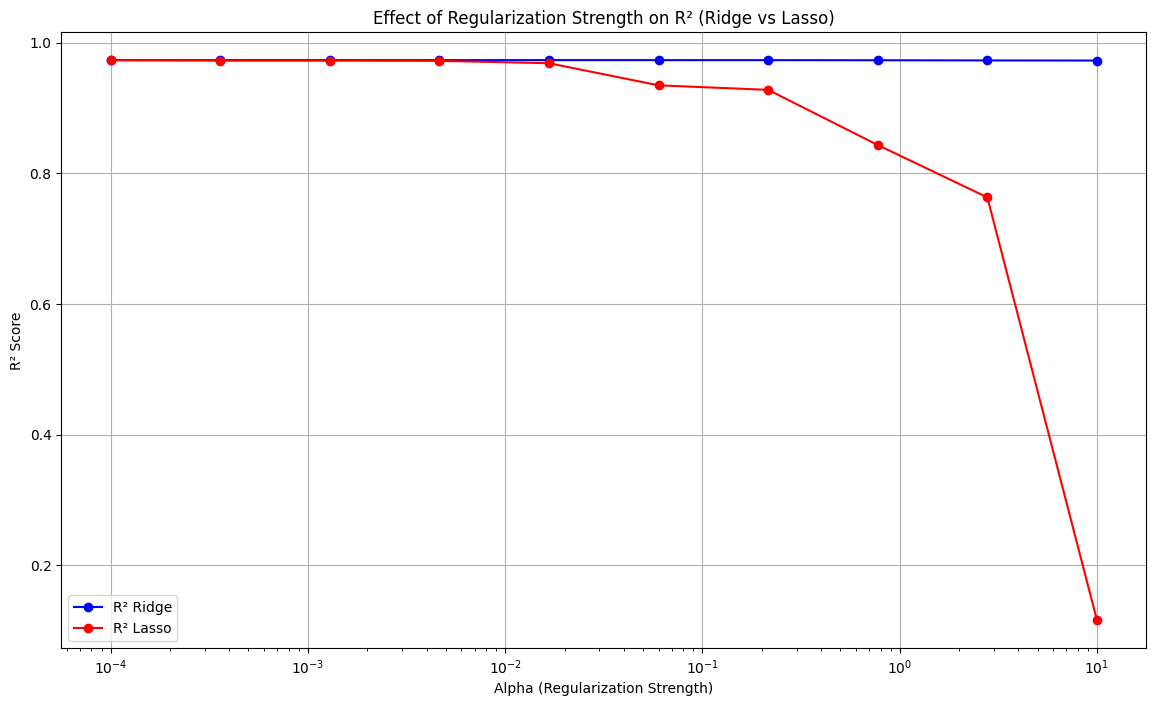

Best Ridge Parameters and Performance:
alpha         0.004642
mae_ridge     0.169702
rmse_ridge    0.226939
r2_ridge      0.973164
mae_lasso     0.169096
rmse_lasso    0.231490
r2_lasso      0.972077
Name: 3, dtype: float64

Best Lasso Parameters and Performance:
alpha         0.000100
mae_ridge     0.169714
rmse_ridge    0.226939
r2_ridge      0.973164
mae_lasso     0.169179
rmse_lasso    0.227218
r2_lasso      0.973098
Name: 0, dtype: float64


In [ ]:
from sklearn.linear_model import Ridge, Lasso
import matplotlib.pyplot as plt

# Define hyperparameters to tune
alphas = np.logspace(-4, 1, 10)  # Values of alpha for Ridge and Lasso
results = {'alpha': [], 'mae_ridge': [], 'rmse_ridge': [], 'r2_ridge': [],
           'mae_lasso': [], 'rmse_lasso': [], 'r2_lasso': []}

# Tuning Ridge and Lasso
for alpha in alphas:
    # Ridge Regression
    ridge = Ridge(alpha=alpha)
    ridge.fit(X_train, y_train)
    y_pred_ridge = ridge.predict(X_test)

    # Evaluate Ridge
    mae_ridge = mean_absolute_error(y_test, y_pred_ridge)
    rmse_ridge = np.sqrt(mean_squared_error(y_test, y_pred_ridge))
    r2_ridge = r2_score(y_test, y_pred_ridge)

    # Lasso Regression
    lasso = Lasso(alpha=alpha)
    lasso.fit(X_train, y_train)
    y_pred_lasso = lasso.predict(X_test)

    # Evaluate Lasso
    mae_lasso = mean_absolute_error(y_test, y_pred_lasso)
    rmse_lasso = np.sqrt(mean_squared_error(y_test, y_pred_lasso))
    r2_lasso = r2_score(y_test, y_pred_lasso)

    # Store results
    results['alpha'].append(alpha)
    results['mae_ridge'].append(mae_ridge)
    results['rmse_ridge'].append(rmse_ridge)
    results['r2_ridge'].append(r2_ridge)
    results['mae_lasso'].append(mae_lasso)
    results['rmse_lasso'].append(rmse_lasso)
    results['r2_lasso'].append(r2_lasso)

# Convert results to a DataFrame for visualization

results_df = pd.DataFrame(results)

# Plot results
plt.figure(figsize=(14, 8))
plt.plot(results_df['alpha'], results_df['r2_ridge'], label='R² Ridge', marker='o', color='blue')
plt.plot(results_df['alpha'], results_df['r2_lasso'], label='R² Lasso', marker='o', color='red')
plt.xscale('log')
plt.xlabel('Alpha (Regularization Strength)')
plt.ylabel('R² Score')
plt.title('Effect of Regularization Strength on R² (Ridge vs Lasso)')
plt.legend()
plt.grid(True)
plt.show()

# Print Best Results
print("Best Ridge Parameters and Performance:")
print(results_df.loc[results_df['r2_ridge'].idxmax()])
print("\nBest Lasso Parameters and Performance:")
print(results_df.loc[results_df['r2_lasso'].idxmax()])


# Random Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor

# Initialize the Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Fit the model
rf_model.fit(X_train, y_train)

# Predict on the test set
y_pred_rf = rf_model.predict(X_test)

# Evaluate the model
mae_rf = mean_absolute_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)

# Print results
print(f"Random Forest Results:")
print(f"Mean Absolute Error (MAE): {mae_rf:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse_rf:.2f}")
print(f"R² Score: {r2_rf:.2f}")


Random Forest Results:
Mean Absolute Error (MAE): 0.05
Root Mean Squared Error (RMSE): 0.09
R² Score: 1.00


Random Forest Review:

The MAE is 0.05 and the RMSE is 0.09. These values are much lower than linear regression. This indicates how Random forest makes significantly fewer and smaller errors.

R^2 score of 1.00 is a perfect score. This score suggests that the model explains almost all variance in the euro_value variable, our target.

This is promising, but it can also indicate overfitting.
Why Random Forest Performs Better:
* Random Forest captures non-linear relationships and feature interactions more effectively than Linear Regression.
* It is robust to outliers and does not rely on assumptions about data distribution.


# Random Forest test for overfitting:

In [ ]:
from sklearn.model_selection import cross_val_score

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
scores = cross_val_score(rf_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
rmse_cv = np.sqrt(-scores.mean())
print(f"Cross-Validated RMSE: {rmse_cv:.2f}")


Cross-Validated RMSE: 0.10


# Random Forest Parameter Tuning

Key hyperparameters to tune:

* n_estimators: Number of trees in the forest (e.g., 50, 100, 200).
* max_depth: Maximum depth of each tree (e.g., None, 5, 10, 20).
* min_samples_split: Minimum samples required to split a node (e.g., 2, 5, 10).
* min_samples_leaf: Minimum samples required in a leaf node (e.g., 1, 2, 5).
* max_features: Number of features to consider when splitting (e.g., 'auto', 'sqrt', 'log2').

Why tune?

They control how the random forest works. Finding the right values for these hyperparameters can significantly improve the model's accuracy. This process is called hyperpramater tuning.

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

# Reduced parameter grid to avoid excessive computation
param_grid = {
    'n_estimators': [100, 200],  # Lower range to avoid memory issues
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2', None]  # Valid values
}

# Initialize Random Forest
rf_model = RandomForestRegressor(random_state=42)

# Perform GridSearchCV
grid_search = GridSearchCV(
    estimator=rf_model,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',  # Minimize MSE
    cv=3,  # Cross-validation
    n_jobs=-1,  # Use all available cores
    verbose=1  # Show progress
)

grid_search.fit(X_train, y_train)

# Best parameters and performance
best_rf_model = grid_search.best_estimator_
y_pred_rf_tuned = best_rf_model.predict(X_test)

# Evaluate tuned model
mae_rf_tuned = mean_absolute_error(y_test, y_pred_rf_tuned)
rmse_rf_tuned = np.sqrt(mean_squared_error(y_test, y_pred_rf_tuned))
r2_rf_tuned = r2_score(y_test, y_pred_rf_tuned)

# Print results
print(f"Random Forest Best Parameters: {grid_search.best_params_}")
print(f"Tuned Random Forest Results:")
print(f"Mean Absolute Error (MAE): {mae_rf_tuned:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse_rf_tuned:.2f}")
print(f"R² Score: {r2_rf_tuned:.2f}")


Fitting 3 folds for each of 72 candidates, totalling 216 fits
Random Forest Best Parameters: {'max_depth': 20, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Tuned Random Forest Results:
Mean Absolute Error (MAE): 0.05
Root Mean Squared Error (RMSE): 0.09
R² Score: 1.00


The best params shall indicate the optimal settings for Random Forest.

Performance metrics are aimed to be better than my initial results.

# Results Analysis

# Gradient Boosting

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

# Initialize Gradient Boosting Regressor
gb_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)

# Fit the model
gb_model.fit(X_train, y_train)

# Predict on the test set
y_pred_gb = gb_model.predict(X_test)

# Evaluate the model
mae_gb = mean_absolute_error(y_test, y_pred_gb)
rmse_gb = np.sqrt(mean_squared_error(y_test, y_pred_gb))
r2_gb = r2_score(y_test, y_pred_gb)

# Print results
print(f"Gradient Boosting Results:")
print(f"Mean Absolute Error (MAE): {mae_gb:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse_gb:.2f}")
print(f"R² Score: {r2_gb:.2f}")


Gradient Boosting Results:
Mean Absolute Error (MAE): 0.08
Root Mean Squared Error (RMSE): 0.10
R² Score: 0.99


# Fine Tuning Gradient Boosting



# Neural Network

In [ ]:
from sklearn.neural_network import MLPRegressor

# Initialize Neural Network Regressor
nn_model = MLPRegressor(hidden_layer_sizes=(100,), activation='relu', solver='adam', max_iter=500, random_state=42)

# Fit the model
nn_model.fit(X_train, y_train)

# Predict on the test set
y_pred_nn = nn_model.predict(X_test)

# Evaluate the model
mae_nn = mean_absolute_error(y_test, y_pred_nn)
rmse_nn = np.sqrt(mean_squared_error(y_test, y_pred_nn))
r2_nn = r2_score(y_test, y_pred_nn)

# Print results
print(f"Neural Network Results:")
print(f"Mean Absolute Error (MAE): {mae_nn:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse_nn:.2f}")
print(f"R² Score: {r2_nn:.2f}")


Neural Network Results:
Mean Absolute Error (MAE): 0.25
Root Mean Squared Error (RMSE): 0.31
R² Score: 0.95


# Fine tuning Neural Networks.

1. Hidden layer Sizes

The number of neurons in each layer and the number of layers. (100,): 1 hidden layer with 100 neurons vs (100,50) 2 hidden layers with 100 neurons.
2. Activate Functions

Controls how signals flow between layers. ReLU, tanh, logistic.
3. Learning Rate

How quickly the model updates weights during training. IF we use a small learning rate, then we can achieve smoother convergence.
4. Optimization solver

Algorithms for weight updates. Adam, sgd. Adam is faster, and sgd is slower but may work better. Will have to test both.
5. Regularization

Penalize large weights to avoid overfitting. Alpha is the strength of L2 regularization.
6. Maximum iterations

Increase the number of passes through the data set if the model struggles to converge to a solution.

Fixes for Stable NN training:
1. Preprocess Data appropriately
2. Regularization
3. Adjust learning rate
4. Use early stopping
5. Debugging

We decided to do another split, this is just a repeated process, it would have worked fine with regular X and y, but we wanted to scale.

In [ ]:
from sklearn.preprocessing import StandardScaler

# Scale the input features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the scaled data
X_train_scaled, X_test_scaled, y_train, y_test = train_test_split(X_scaled, y, test_size=0.34, random_state=42)


In [ ]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Pipeline with scaling and neural network
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('nn', MLPRegressor(random_state=42, early_stopping=True, validation_fraction=0.2, n_iter_no_change=10))
])

# Define parameter grid
param_grid = {
    'nn__hidden_layer_sizes': [(100,), (50, 50), (100, 50, 25)],
    'nn__activation': ['relu', 'tanh'],
    'nn__solver': ['adam'],
    'nn__learning_rate_init': [0.0005, 0.001],
    'nn__alpha': [0.0001, 0.001, 0.01],  # Regularization
    'nn__max_iter': [500]
}

# Grid search
grid_search_nn = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=3,
    n_jobs=-1,
    verbose=1,
    error_score='raise'  # Debug configurations causing errors
)

# Fit the model
grid_search_nn.fit(X_train, y_train)

# Best parameters and evaluation
best_nn_model = grid_search_nn.best_estimator_
y_pred_nn_tuned = best_nn_model.predict(X_test_scaled)

# Evaluate tuned neural network
mae_nn_tuned = mean_absolute_error(y_test, y_pred_nn_tuned)
rmse_nn_tuned = np.sqrt(mean_squared_error(y_test, y_pred_nn_tuned))
r2_nn_tuned = r2_score(y_test, y_pred_nn_tuned)

print(f"Neural Network Best Parameters: {grid_search_nn.best_params_}")
print(f"Tuned Neural Network Results:")
print(f"Mean Absolute Error (MAE): {mae_nn_tuned:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse_nn_tuned:.2f}")
print(f"R² Score: {r2_nn_tuned:.2f}")


Fitting 3 folds for each of 36 candidates, totalling 108 fits
Neural Network Best Parameters: {'nn__activation': 'tanh', 'nn__alpha': 0.01, 'nn__hidden_layer_sizes': (100, 50, 25), 'nn__learning_rate_init': 0.001, 'nn__max_iter': 500, 'nn__solver': 'adam'}
Tuned Neural Network Results:
Mean Absolute Error (MAE): 2.15
Root Mean Squared Error (RMSE): 3.06
R² Score: -3.72


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


# Comparison Table

Take best model of each algorithm, and compare.

We can also entries of the table for each parameterized model if they are worth showing.

# Finding important features for market value prediction
1. Feature improtance via Random Forest
2. Correlation Heatmap
3. Recursive feature elimination (RFE)

# Feature importance via Random Forest

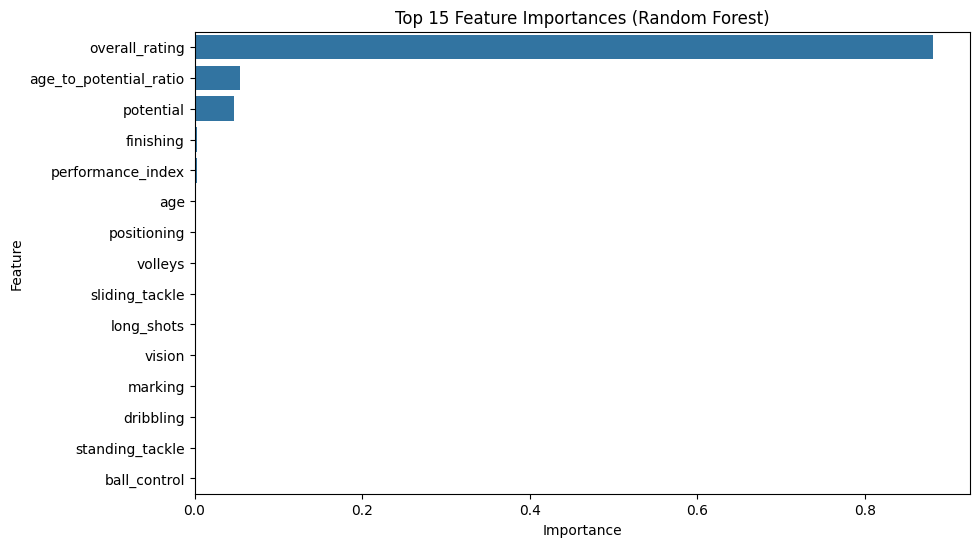

In [ ]:
# Feature importance from Random Forest
importances = best_rf_model.feature_importances_
feature_names = X.columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(15))  # Top 15 features
plt.title('Top 15 Feature Importances (Random Forest)')
plt.show()


# Correlation Heatmap, already done above.

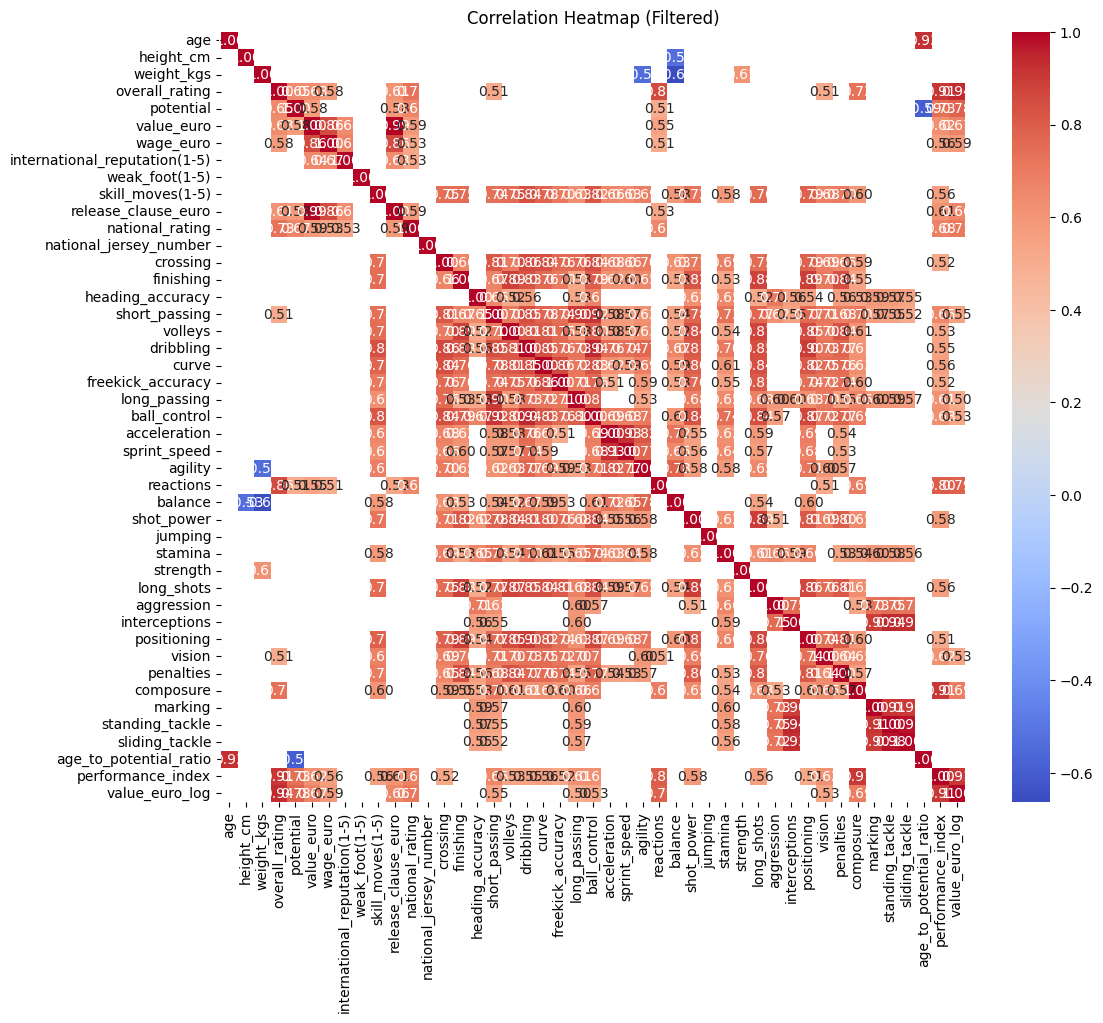

In [ ]:
plt.figure(figsize=(12, 10))

#correlation_matrix = data.corr()
#Can only find correlation between numerical data.
# Calculate correlations only for numeric columns
correlation_matrix = data.select_dtypes(include=np.number).corr()

# Filter for correlations above a certain threshold (e.g., 0.5)
threshold = 0.5
filtered_correlation_matrix = correlation_matrix[abs(correlation_matrix) >= threshold]

# Plot the heatmap with the filtered matrix
sns.heatmap(filtered_correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap (Filtered)')
plt.show()

# RFE (Recursive feature Elimination)
Top 10 features

In [ ]:
from sklearn.feature_selection import RFE

# Perform RFE with Random Forest
rfe = RFE(estimator=RandomForestRegressor(n_estimators=100, random_state=42), n_features_to_select=10)
rfe.fit(X, y)

# Print selected features
selected_features = X.columns[rfe.support_]
print("Top Features Selected by RFE:", selected_features)


Top Features Selected by RFE: Index(['age', 'overall_rating', 'potential', 'finishing', 'volleys',
       'dribbling', 'positioning', 'sliding_tackle', 'age_to_potential_ratio',
       'performance_index'],
      dtype='object')


# How to account for inflation?
1. Obtain a dataset of anual inflation rates (Consumer Price Index)
2. Add a year column to our dataset.
3. Apply the adjustment:

Adjusted value = Market Value * inflation index(base year)/inflation index(current year)

In [ ]:
# Find an inflation data set for all years, need to find the market value of each player coming from which year. It seems to be 2017.
# This data set spans multiple years, so we need to adjust market value for each player.


# Incorporation of deep learning methods

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


354/354 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 45.6304 - mae: 4.9058 - val_loss: 1.4121 - val_mae: 0.9522
Epoch 2/50
354/354 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.1916 - mae: 1.1793 - val_loss: 0.9103 - val_mae: 0.7595
Epoch 3/50
354/354 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.6788 - mae: 1.0294 - val_loss: 0.7892 - val_mae: 0.6960
Epoch 4/50
354/354 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.2880 - mae: 0.8976 - val_loss: 0.4980 - val_mae: 0.5614
Epoch 5/50
354/354 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.0695 - mae: 0.8180 - val_loss: 0.3608 - val_mae: 0.4776
Epoch 6/50
354/354 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.9261 - mae: 0.7606 - val_loss: 0.2918 - val_mae: 0.4171
Epoch 7/50
354/354 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.7601 - mae: 0.6878 - val_loss: 0.2529 - val_mae: 0.3930
Epoch 8/50
354/354 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6141 - mae: 0.6205 - val_loss: 0.2116 - val_mae: 0.3655
Epoch 9/50
354/354 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5345

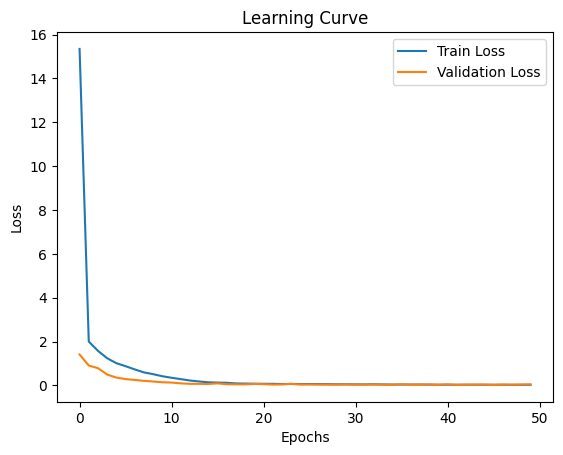

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler

# Scale data (if not already scaled)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the scaled data
X_train_scaled, X_test_scaled, y_train, y_test = train_test_split(X_scaled, y, test_size=0.34, random_state=42)

# Build a sequential model
model = Sequential([
    Dense(128, activation='relu', input_dim=X_train_scaled.shape[1]),
    Dropout(0.2),  # Regularization
    Dense(64, activation='relu'),
    Dense(1, activation='linear')  # Single output for regression
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

# Train the model
history = model.fit(X_train_scaled, y_train, validation_split=0.2, epochs=50, batch_size=32, verbose=1)

# Evaluate the model
results = model.evaluate(X_test_scaled, y_test, verbose=0)
print(f"Test Loss (MSE): {results[0]:.4f}, Test MAE: {results[1]:.4f}")

# Visualize learning curves
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Learning Curve')
plt.show()


# We can use advanced feature engineering to capture non-linear relationships.
More work to be done later on this if required.

In [ ]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_poly = poly.fit_transform(X)

print(f"Original Shape: {X.shape}, After Polynomial Expansion: {X_poly.shape}")

Original Shape: (17699, 40), After Polynomial Expansion: (17699, 820)


# We can use a stacking model of random forest, gradient boosting, and neural network to create a meta model for improved preformance.

In [ ]:
from sklearn.ensemble import StackingRegressor

stacking_model = StackingRegressor(
    estimators=[
        ('rf', RandomForestRegressor(n_estimators=100, random_state=42)),
        ('gb', GradientBoostingRegressor(n_estimators=100, random_state=42)),
        ('nn', MLPRegressor(hidden_layer_sizes=(100,), max_iter=500, random_state=42))
    ],
    final_estimator=LinearRegression()
)

stacking_model.fit(X_train, y_train)
y_pred_stacking = stacking_model.predict(X_test)

mae_stacking = mean_absolute_error(y_test, y_pred_stacking)
print(f"Stacking Model MAE: {mae_stacking:.2f}")

Stacking Model MAE: 0.05


# Or we can include Voting Regressor

In [ ]:
from sklearn.ensemble import VotingRegressor

voting_model = VotingRegressor([
    ('rf', best_rf_model),
    ('gb', GradientBoostingRegressor(n_estimators=100, random_state=42)),
    ('nn', MLPRegressor(hidden_layer_sizes=(100,), max_iter=500, random_state=42))
])

voting_model.fit(X_train, y_train)
y_pred_voting = voting_model.predict(X_test)
print(f"Voting Regressor MAE: {mean_absolute_error(y_test, y_pred_voting):.2f}")

Voting Regressor MAE: 0.09


# Custom Model Implementation
Consider feature selection for any methods that do not perform well with unnecessary features

In [ ]:
import numpy as np

# Closed-form solution for Linear Regression
def train_linear_regression(X, y):
    # Add bias term
    X_bias = np.c_[np.ones(X.shape[0]), X]
    # Compute weights: w = (X^T X)^-1 X^T y
    # Fix: Ensure y has the same number of rows as X_bias
    weights = np.linalg.inv(X_bias.T @ X_bias) @ X_bias.T @ y[:X_bias.shape[0]]
    return weights

# Training
weights = train_linear_regression(X_train.values, y_train.values)

# Prediction
X_test_bias = np.c_[np.ones(X_test.shape[0]), X_test.values]
y_pred_custom = X_test_bias @ weights

# Evaluation
mae_custom = mean_absolute_error(y_test, y_pred_custom)
print(f"Custom Linear Regression MAE: {mae_custom:.2f}")

Custom Linear Regression MAE: 4.86


# Taking into account:
Consider feature selection for any methods that do not perform well with unnecessary features

In [ ]:
import numpy as np
from sklearn.feature_selection import SelectKBest, f_regression  # Import for feature selection

# Closed-form solution for Linear Regression with feature selection
def train_linear_regression(X, y, k=10):  # Added k for number of features to select
    # Feature selection using SelectKBest and f_regression
    selector = SelectKBest(f_regression, k=k)  # Select top k features
    X_new = selector.fit_transform(X, y)

    # Add bias term
    X_bias = np.c_[np.ones(X_new.shape[0]), X_new]
    # Compute weights: w = (X^T X)^-1 X^T y
    weights = np.linalg.inv(X_bias.T @ X_bias) @ X_bias.T @ y[:X_bias.shape[0]]
    return weights, selector  # Return the selector for later use

# Training with feature selection
weights, selector = train_linear_regression(X_train.values, y_train.values, k=20)  # Select 20 features

# Prediction (apply feature selection to test data)
X_test_selected = selector.transform(X_test.values)  # Transform test data using the selector
X_test_bias = np.c_[np.ones(X_test_selected.shape[0]), X_test_selected]
y_pred_custom = X_test_bias @ weights

# Evaluation
mae_custom = mean_absolute_error(y_test, y_pred_custom)
print(f"Custom Linear Regression MAE (with feature selection): {mae_custom:.2f}")

Custom Linear Regression MAE (with feature selection): 0.86


# Advanced Statistical Analysis

Analyze the Residuals.

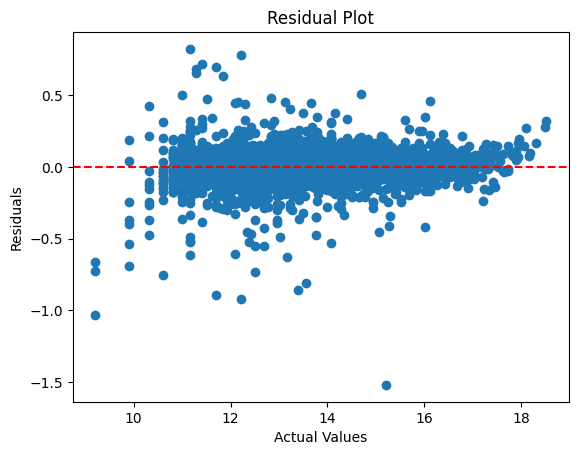

In [ ]:
residuals = y_test - y_pred_rf #y_pred_rf from default random forest.
plt.scatter(y_test, residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Actual Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()